Solo-queue Multitask RNN - Learns targets such as damage dealt, game duration & gold @ 10 mins in addition to match winner

In [1]:
from new_model import *
from Graphing import *

In [2]:
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("d_all")
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((88444, 27), (88444, 2250), 2250, (16, 125), 125, (88444, 13), (88444, 160))

In [5]:
meta,X,Yc,Yr,(meta_labels,X_labels,Yc_labels,Yr_labels) = load_ld("d_lorb")
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((87743, 37), (87743, 4266), 4266, (16, 125), 125, (87743, 13), (87743, 160))

Remove redundant/leaky/zero features

In [7]:
meta, X, meta_labels, X_labels = clean_features(meta, X, meta_labels, X_labels)
X, X_labels = filter_features(X, X_labels)
# X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "ravg_" in l])  # Recent matches averages; we use raw data
X, X_labels, X_rec, X_rec_labels = remove_redundant_features(X, X_labels, X_rec, X_rec_labels)
rem_is = []
for i in range(X.shape[1]):
    if np.sum(X[:, i]) == 0:
        rem_is.append(i)
print(len(rem_is), "zero features removed")  # Usually just the older patch indicators for which we have no data
X, X_labels = remove_data_subset(X, X_labels, [X_labels[i] for i in rem_is])
meta.shape, X.shape, len(X_labels), len(X_rec), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((87743, 47),
 (87743, 2250),
 2250,
 87743,
 (16, 81),
 81,
 (87743, 13),
 (87743, 160))

Exclude games for which we have no recent match history data (crawler bug/connection issues)

In [3]:
rem_is = []
for i in range(len(meta)):
    if all([len(X_rec[i][j]) == 0 for j in N_PL_r]):
        rem_is.append(i)
len(rem_is)
meta, X, X_rec, Yc, Yr = remove_data_inds(meta, X, X_rec, Yc, Yr, rem_is)
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((87743, 27), (87743, 2250), 2250, (16, 125), 125, (87743, 13), (87743, 160))

Clean and format recent matches features

In [9]:
X_rec, X_rec_labels = get_rec_feats(X_rec, X_rec_labels)
len(X), X_rec[0][0].shape, len(X_rec_labels)

87700 / 87743      2019-09-30 08:27:32


(87743, (16, 94), 94)

Save/load checkpoint

In [10]:
save_ld((meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels)), "d_lorbnn")
# meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("d_lorbnn")

Shuffle data

In [11]:
# Shuffle dataset (list of arrays + X_rec (recent games list of lists))
shuf_idx = load_ld("model_formats/rnn_mt_model.data", pad=False)["shuf_idx"]
meta, X, Yc, Yr, X_rec, shuf_idx = shuffle_data([meta, X, Yc, Yr], X_rec, return_idx=True, indices=shuf_idx)
# meta, X, Yc, Yr, X_rec, shuf_idx = shuffle_data([meta, X, Yc, Yr], X_rec, return_idx=True)

Make input arrays for champions, pick positions and spells

In [12]:
if "blue_top_champion" in X_labels:
    champ_labels = [X_labels.index(r + "_champion") for r in t_roles]
    pickpos_labels = [X_labels.index(r + "_pick_position") for r in t_roles]
    X_champions = X[:, champ_labels].astype(int)
    X_pick_positions = X[:, pickpos_labels].astype(int)
    X_pick_positions = X_pick_positions - 1   # Convert pick positions to indices
    champ_code_is = list(champ_codes.keys())  # Convert champion ids to indices
    champ_idx = np.zeros(max(champ_code_is) + 1, dtype=int)
    for i in range(len(champ_code_is)):
        champ_idx[champ_code_is[i]] = i
    for i in range(10):
        X_champions[:, i] = champ_idx[X_champions[:, i]]
    X_labels = [X_labels[i] for i in range(len(X_labels)) if i not in champ_labels + pickpos_labels]
    X = X[:, [i for i in range(X.shape[1]) if i not in champ_labels + pickpos_labels]]
X.shape, len(X_labels)

((87743, 2230), 2230)

In [13]:
if "blue_top_spell_1" in X_labels:
    spell1_labels = [X_labels.index(r + "_spell_1") for r in t_roles]
    spell2_labels = [X_labels.index(r + "_spell_2") for r in t_roles]
    X_spell1s = X[:, spell1_labels].astype(int)
    X_spell2s = X[:, spell2_labels].astype(int)
    X_labels = [X_labels[i] for i in range(len(X_labels)) if i not in spell1_labels + spell2_labels]
    X = X[:, [i for i in range(X.shape[1]) if i not in spell1_labels + spell2_labels]]
X.shape, len(X_labels)

((87743, 2210), 2210)

Create team sum versions of regression targets

In [14]:
base_labels = []
r = t_roles[0]
r_len = len(r)
for l in Yr_labels:
    if l[:r_len] == r:
        base_labels.append( l[r_len + 1:] )
Yr_totals = []
for l in base_labels:
    if "total_" + l not in Yr_labels:
        Yr_totals.append( [Yr[:, Yr_labels.index(r + '_' + l)] for r in t_roles] )
        Yr_labels.append( "total_" + l )
Yr_teams = []
for l in base_labels:
    for c in cols_all:
        if c + '_' + l not in Yr_labels:
            Yr_teams.append( [Yr[:, Yr_labels.index(c + '_' + r + '_' + l)] for r in roles_all] )
            Yr_labels.append( c + '_' + l )
if len(Yr_totals) > 0: Yr_totals = np.sum(Yr_totals, axis=1).T
if len(Yr_teams) > 0: Yr_teams = np.sum(Yr_teams, axis=1).T
if len(Yr_totals) > 0 or len(Yr_teams) > 0: Yr = np.hstack([Yr, Yr_totals, Yr_teams])
Yr.shape, len(Yr_labels)

((87743, 208), 208)

Add game duration as a regression target (instead of an input feature, if present)

In [15]:
X, X_labels = remove_data_subset(X, X_labels, duration_labels)
if "duration" not in Yr_labels:
    Yr = np.hstack([Yr, np.atleast_2d([meta[:, meta_labels.index("duration")]]).T])
    Yr_labels.append("duration")
X.shape, len(X_labels), Yr.shape, len(Yr_labels)

((87743, 2210), 2210, (87743, 209), 209)

Define training set size. Future transformations will depend on this value

In [16]:
n_train = 70000

Data normalization/feature scaling (for data other than recent match histories)

In [17]:
print(Yr.min(), X.min(), Yr.max(), X.max()) # Scale data to between 0 & 1 (remember scaling values)
X_scales, X_scalesdict = scale_data(X, X_labels, n_train)
Yr_scales, Yr_scalesdict = scale_data(Yr, Yr_labels, n_train)
print(Yr.min(), X.min(), Yr.max(), X.max())

0.0 -204773.96628136368 5810674.0 468080.64
0.0 -0.5117364008386261 1.003875968992248 1.3283014541354323


In [18]:
# unscale_data(X, X_labels, X_scales) # Unscale
# unscale_data(Yr, Yr_labels, Yr_scales)
# print(Yr.min(), X.min(), Yr.max(), X.max())

In [19]:
scaler = RobustScaler()
scaler.fit(X[:n_train])
X = scaler.transform(X)

In [20]:
# Scale recent matches data to zero median & unit interquartile range
rec_median, rec_iqr = scale_rec_data(X_rec[:5000], X_rec_labels)
rec_median = rec_median.astype(np.float32)
rec_iqr = rec_iqr.astype(np.float32)

94 / 94     

Pad recent matches data so we can feed into RNN

In [21]:
rec_max_len = 20 # Maximum number of recent games to use in RNN
n_rec_features = len(X_rec_labels)
def convert_X_rec(Xr, inds=None, max_len=rec_max_len):
    if inds is not None: Xr = Xr[inds]
    xrs_seqlens = [np.array([min(max(x_[j].shape[0], 1), max_len) for x_ in Xr]).astype(np.int32) for j in N_PL_r]
    xrs = [np.array([np.pad(x_[j][-max_len:].astype(float), [(0, max_len - x_[j][-max_len:].shape[0]), (0, 0)], \
      'constant') if len(x_[j])>0 else np.zeros((max_len,n_rec_features)) for x_ in Xr]).astype(np.float32) for j in N_PL_r]
    return xrs, xrs_seqlens

In [22]:
per_batch = 20000
n_samples = len(X_rec)
n_parr = n_samples // per_batch
Xr = [np.empty((n_samples, 20, len(X_rec_labels))) for _ in N_PL_r]
Xr_seqlens = [np.empty((n_samples)) for _ in N_PL_r]
for parr_i in range(n_parr + 1):
    start_i = parr_i * per_batch
    end_i = min(start_i + per_batch, n_samples)
    out, osl = convert_X_rec(X_rec[:per_batch])
    for i in N_PL_r:
        Xr[i][start_i:end_i] = out[i]
        Xr_seqlens[i][start_i:end_i] = osl[i]
    if parr_i != n_parr:
        del X_rec[:per_batch]
    else:
        del X_rec
    gc.collect()
    sys_print("\r" + str(end_i))

87743

Define model input format (save for inference deployment)

In [23]:
stuff = locals()
model_inp_form = {name: stuff[name] for name in [
    "X_labels",
    "X_rec_labels",
    "X_scales",
    "X_scalesdict",
    "Yr_scales",
    "Yr_scalesdict",
    "scaler",
    "rec_median",
    "rec_iqr",
    "shuf_idx",
]}

Save/load checkpoint

In [24]:
save_ld((meta,X,Xr,Xr_seqlens,X_champions,X_pick_positions,X_spell1s,X_spell2s,Yc,Yr,\
         (meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels),model_inp_form), "d_lorbnn_sc")
# meta,X,Xr,Xr_seqlens,X_champions,X_pick_positions,X_spell1s,X_spell2s,Yc,Yr,\
#          (meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels),model_inp_form = load_ld("d_lorbnn_sc")
# rec_median = model_inp_form["rec_median"]
# rec_iqr = model_inp_form["rec_iqr"]
# rec_max_len = 20 # Maximum number of recent games to use in RNN
# n_rec_features = len(X_rec_labels)

Define objectives and training inputs

In [25]:
Yc_use = [                                                      # Classification targets
    "blue_win",
#     "blue_first_tower",
#     "blue_first_dragon",
#     "blue_first_inhib",
#     "blue_first_blood",
#     "blue_rift_herald",
#     "blue_first_baron",
]
Yr_use = [                                                      # Regression targets
    "duration",
] + sum([[role + '_' + l for l in [                             # Individual players
#     "total_damage_dealt_to_champions",
#     "total_time_crowd_control_dealt",
    "time_ccing_others",
    "vision_score",
#     "gold",
#     "gold_10min",
    "creep_score_10min",
#     "xp_10min",
]] for role in t_roles], []) + sum([[c + '_' + l for l in [     # Team sums
#     "total_damage_dealt_to_champions",
#     "total_time_crowd_control_dealt", # ?
#     "time_ccing_others",
#     "vision_score", # ?
#     "gold",
#     "gold_10min",
#     "creep_score_10min",
#     "xp_10min",
]] for c in cols_all], []) + ["total_" + l for l in [           # Total sums
#     "total_damage_dealt_to_champions",
#     "total_time_crowd_control_dealt", # ?
#     "time_ccing_others",
#     "vision_score", # ?
#     "gold",
    "gold_10min",
#     "creep_score_10min",
#     "xp_10min",
]]

Yc_targets = []
for l in Yc_use: # Get one-hot version of classification targets
    Yc_t = np.atleast_2d(Yc[:, Yc_labels.index(l)])
    Yc_t_ = np.zeros((Yc_t.size, int(Yc_t.max()) + 1))
    Yc_t_[np.arange(Yc_t.size), (Yc_t).astype(np.int)] = 1
    Yc_targets.append(Yc_t_)
Yr_targets = [np.atleast_2d(Yr[:, Yr_labels.index(l)]).T for l in Yr_use]

# Number of test samples
n_test = X.shape[0] - n_train
X_train, X_test = X[:-n_test], X[-n_test:]
Xr_train, Xr_test = [xr[:-n_test] for xr in Xr], [xr[-n_test:] for xr in Xr]
Xr_sl_train, Xr_sl_test = [xr_sl[:-n_test] for xr_sl in Xr_seqlens], [xr_sl[-n_test:] for xr_sl in Xr_seqlens]
X_champions_train, X_champions_test = X_champions[:-n_test], X_champions[-n_test:]
X_pick_positions_train, X_pick_positions_test = X_pick_positions[:-n_test], X_pick_positions[-n_test:]
X_spell1s_train, X_spell1s_test = X_spell1s[:-n_test], X_spell1s[-n_test:]
X_spell2s_train, X_spell2s_test = X_spell2s[:-n_test], X_spell2s[-n_test:]
Yc_train, Yc_test = [Yc_[:-n_test] for Yc_ in Yc_targets], [Yc_[-n_test:] for Yc_ in Yc_targets]
Yr_train, Yr_test = [Yr_[:-n_test] for Yr_ in Yr_targets], [Yr_[-n_test:] for Yr_ in Yr_targets]
n_features = X_train.shape[1]
n_outputs = [Yc_.shape[1] for Yc_ in Yc_train]
X_train.shape, Xr_train[0].shape, Xr_test[0].shape, Xr_sl_train[0].shape, Xr_sl_test[0].shape, \
    n_train, n_test, n_features, n_outputs, len(Yc_targets), len(Yr_targets), \
    Yc_targets[0].shape, Yr_targets[0].shape, rec_max_len, n_rec_features

((70000, 2210),
 (70000, 20, 94),
 (17743, 20, 94),
 (70000,),
 (17743,),
 70000,
 17743,
 2210,
 [2],
 1,
 32,
 (87743, 2),
 (87743, 1),
 20,
 94)

Filter test data to test prediction for games above an elo skill rating of ```elo_N```

In [26]:
elo_N = 2400
high_elo_test_is = np.nonzero(meta[-n_test:, meta_labels.index("elo")] > elo_N)[0].astype(np.int32)
len(high_elo_test_is)

2402

Get elo and region feature indices for rnn begin token

In [27]:
X_eloreg_idx = np.asarray([X_labels.index(l) for l in X_labels if l == "elo" or l[:9] == "region__x"]).astype(np.int32)
X_eloreg_idx.shape

(12,)

Get feature mins for auto log scaling layer

In [28]:
Xr_mins = [np.min(np.min(Xr_, axis=0), axis=0) for Xr_ in Xr_train]
X_mins = np.min(X_train, axis=0)
min(X_mins)

-30.200269189548077

Fit, train & test models, save results

In [29]:
import tensorflow as tf
from tensorflow.contrib import rnn
from IPython.display import clear_output
from tensorflow.layers import batch_normalization as bnorm
from tensorflow.nn import dropout, relu, leaky_relu
from AMSGrad import AMSGrad

In [32]:
model_name = "rnn_mt_model_no_rnn"
blue_win_i = Yc_use.index("blue_win")
train_set_test_frac = 0.2 # Get training accuracy for random 20% subset of train set
log_period_batches = 25
n_epochs = 500000
learning_rate_amsgrad = 3.5 * 1e-5
# learning_rate_adam = 3.5 * 1e-5
# learning_rate_sgd = 0.01
dropout_keep_prob = 0.67
dropout_rnn = 0.55
batch_size = 256
lstm_forget_bias = 1.0
c_type = "GRU"

pre_rnn1_units = 256
# pre_rnn2_units = 256
# pre_rnn3_units = 256
# pre_rnn_shared_units = 256
n_rnn_units = 256
n_rnn_stacked = 1
post_rnn_units = 256
pre_join_x_units = 4096
l1_n_units = 4096
l2_n_units = 4096
l3_n_units = 4096
l4_n_units = 4096
# l5_n_units = 4096
# l6_n_units = 4096
# final_layer_units = 4096

# Define next batch function
current_i, epochs_completed = 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)
def next_batch(sz):
    global epoch_shuf, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    xs = X_train[batch_idx]
    xrs = [Xr_[batch_idx] for Xr_ in Xr_train]
    xrsls = [Xr_sl_[batch_idx] for Xr_sl_ in Xr_sl_train]
    x_chmps = X_champions_train[batch_idx]
    x_pposs = X_pick_positions_train[batch_idx]
    x_spell1s = X_spell1s_train[batch_idx]
    x_spell2s = X_spell2s_train[batch_idx]
    ycs = [Yc_[batch_idx] for Yc_ in Yc_train]
    yrs = [Yr_[batch_idx] for Yr_ in Yr_train]
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        np.random.shuffle(epoch_shuf)
        epochs_completed += 1
    return xs, xrs, xrsls, x_chmps, x_pposs, x_spell1s, x_spell2s, ycs, yrs

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

def beta_swish(x):
    beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
    return x * tf.nn.sigmoid(beta * x)
def swish(x):
    return x * tf.nn.sigmoid(x)
def autolog(x, x_min, n_feats):
    with tf.name_scope("autolog"):
        x_ = tf.clip_by_value(x, -4.5, 4.5)
        alpha = tf.Variable(initial_value=np.tile(0.15, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
        beta = tf.Variable(initial_value=np.tile(0.4, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
        gamma = tf.Variable(initial_value=np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
        act = (alpha * x) + \
            tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
        tf.summary.histogram("autolog_alpha", alpha)
        tf.summary.histogram("autolog_beta", beta)
        tf.summary.histogram("autolog_gamma", gamma)
        tf.summary.histogram("autolog_activation", act)
        return act

x = tf.placeholder(tf.float32, [None, n_features], name='x')
xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name="x_" + r + "_rnn") for r in t_roles]
xrsl = [tf.placeholder(tf.int32, [None], name="seq_len_" + r) for r in t_roles]
x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name=Yc_use[i] + "_labels") for i in range(len(Yc_targets))]
yr = [tf.placeholder(tf.float32, [None, 1], name=(Yr_use[i] if f2(Yr_use[i]) not in t_roles else \
        '_'.join(Yr_use[i].split('_')[2:] + [f2(Yr_use[i])])) + "_targets") for i in range(len(Yr_targets))]
keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

n_champions = len(champ_dict)
n_input_feats = n_features + (n_champions * 2) + (N_PL ** 2) + (n_spells * N_PL)

def bnorm_appl(inp):
    return dropout(bnorm(inp), keep_prob)

# with tf.name_scope("metadata"):
# #     b_size = tf.shape(x)[0]
#     x_eloreg = tf.gather(x, X_eloreg_idx, axis=1)

# with tf.name_scope("past_games"):
#     xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
#     xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), Xr_mins[i], n_rec_features) for i in N_PL_r]
# with tf.name_scope("recurrent"):
#     # Construct pre-rnn layers
#     with tf.name_scope("pre_rnn_fc"):
#         Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
#         Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
#         # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
#         # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
#         # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
#         # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
#         # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
#         # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

#         pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] for i in N_PL_r]
#         # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
#         # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
#         # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
#         pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) for i in N_PL_r]

#     with tf.name_scope("rnn"):
#         def get_rnn_cell(c_type, lstm_forget_bias, kp):
#           cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
#                  rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell")
#           return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
#         if n_rnn_stacked > 1:
#         #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
#             cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
#         else:
#         #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
#             cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)
        
#         with tf.name_scope("rnn_beginToken_W"):
# #             W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
#             W_begin_token = [tf.Variable(izer([len(X_eloreg_idx), n_rnn_units]), name=r) for r in roles_all]
#         with tf.name_scope("rnn_beginToken_b"):
#             b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

#         # Define rnn cell initial state
#         init_states = [tf.matmul(x_eloreg, W_begin_token[i]) + b_begin_token[i] for i in range(5)]
# #         init_states = [tf.tile(W_begin_token[i], [tf.shape(xrsl[0])[0], 1]) for i in range(5)]
#         rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i % 5],
#                                     dtype=tf.float32) for i in N_PL_r])
#         # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
#         #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
#         #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
#         rnn_outs = [tf.gather_nd(rnn_os[i], tf.stack([tf.range(tf.shape(rnn_os[i])[0]), xrsl[i] - 1], axis=1)) for i in N_PL_r]

#     with tf.name_scope("post_rnn_fc"):
#         Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
#         Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
#         Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
#         # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

#         post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) for i in N_PL_r]
#         rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

with tf.name_scope("team_compositions"):
    # Add champion compositions and pick positions
    x_champsum = tf.one_hot(x_chmp, n_champions)
    x_pposes = tf.one_hot(x_ppos, N_PL)
    x_ch_bsum = tf.reduce_sum(x_champsum[:, :5], axis=1)
    x_ch_rsum = tf.reduce_sum(x_champsum[:, 5:], axis=1)
    x_spellsum = tf.one_hot(x_spell1, n_spells) + tf.one_hot(x_spell2, n_spells)
    x_input = tf.concat([autolog(x, X_mins, n_features),
                         x_ch_bsum,
                         x_ch_rsum,
                         tf.reshape(x_pposes, [-1, N_PL ** 2]),
                         tf.reshape(x_spellsum, [-1, N_PL * n_spells])], axis=1)

with tf.name_scope("fully_connected"):
    Wp_1 = tf.Variable(izer([n_input_feats, pre_join_x_units]), name='W_xin_linear')
    bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

    W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
    # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
    b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
    W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
    b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
    W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
    b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
    W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
    b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
    # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
    # b_5 = tf.Variable(izer([l5_n_units]))
    # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
    # b_6 = tf.Variable(izer([l6_n_units]))
    # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
    # b_7 = tf.Variable(izer([n_outputs]))

    pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

    relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1)
#     relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum(rnn_l1))  # Sum join
    # relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

    relu_2 = bnorm_appl(tf.matmul(relu_1, W_2) + b_2)
    relu_3 = bnorm_appl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
    relu_4 = bnorm_appl(tf.matmul(relu_3, W_4) + b_4)
    # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
    # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
    # drop_out = dropout(relu_2, keep_prob)
    # y_out = tf.matmul(drop_out, W_3) + b_3
    # y_out = tf.matmul(relu_3, W_4) + b_4
    #   y_prob = tf.nn.softmax(y_out)

with tf.name_scope("final_output"):
    # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
    # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
    # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
    # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
    # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
    # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
    # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
    # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

    with tf.name_scope("output_W"):
        Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
        Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
    with tf.name_scope("output_b"):
        Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
        Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

    # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
    # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
    # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
    # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

    with tf.name_scope("classif_outs"):
        Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
    with tf.name_scope("regr_outs"):
        Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

# Define loss function & training step
with tf.name_scope("loss"):
    with tf.name_scope("classif_xent_loss"):
        Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                     labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
    with tf.name_scope("regr_l2_losses"):
        Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
#         loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
    loss = sum(Yc_losses) + (5.0 * (10**-5) * tf.reduce_mean(Yr_losses))

with tf.name_scope("train"):
    train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
    # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)
#     train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_sgd).minimize(loss)

with tf.name_scope("accuracy"):
    # Define accuracy computation
    correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
    accuracy = tf.reduce_mean(correct)
    accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
merged_summary = tf.summary.merge_all()

# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()
create_folder("models")
create_folder("models/" + model_name)
create_folder("model_formats")
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")
# save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False) # comment this out if restoring / testing

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Epoch 27 : 0.9992143 0.64701575 0.6140716 loss: 0.016741011 2.5680203 Best test acc res: 0.7565714 0.68770784 0.65445465 75


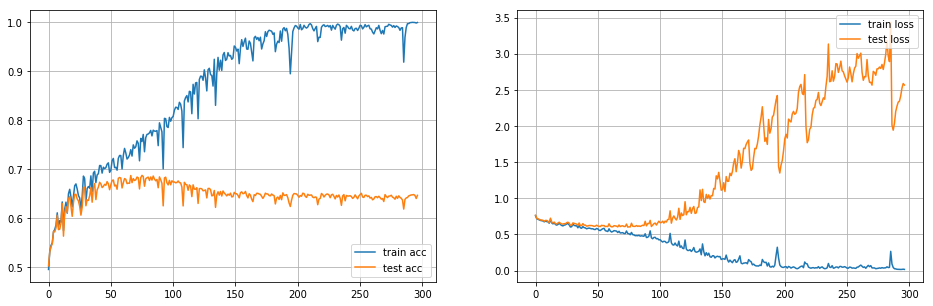

Batch 7432 (1902592 samples) complete

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    create_folder("logs/tensorboard/" + model_name, overwrite=True)
    writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
    writer.add_graph(sess.graph)
    while epochs_completed < n_epochs:

        batch_i += 1
        batch_xs, batch_xrs, batch_xrsls, batch_xchs, batch_xppos, \
            batch_xspell1, batch_xspell2, batch_ycs, batch_yrs = next_batch(batch_size)
        xrs_feed = {xr[i]: batch_xrs[i] for i in N_PL_r}
        xrsls_feed = {xrsl[i]: batch_xrsls[i] for i in N_PL_r}
        ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
        sess.run([train_step], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
            **{x: batch_xs, x_chmp: batch_xchs, x_ppos: batch_xppos, x_spell1: batch_xspell1, x_spell2: batch_xspell2, \
               keep_prob: dropout_keep_prob, rnn_kp: dropout_rnn}})
#         writer.add_summary(s, batch_i)
        sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')

        if batch_i % log_period_batches == 0:
            indices = np.random.choice(n_train, n_train_test, replace=False)
            xrs_feed = {xr[i]: Xr_train[i][indices] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_train[i][indices] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
            train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                   {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                 **{x: X_train[indices], x_chmp: X_champions_train[indices], x_ppos: X_pick_positions_train[indices], \
                    x_spell1: X_spell1s_train[indices], x_spell2: X_spell2s_train[indices], \
                    keep_prob: 1.0, rnn_kp: 1.0}})
            
            xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
            test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                  {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
                   x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
                   keep_prob: 1.0, rnn_kp: 1.0}})
            
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc:
                best_acc = test_a
                best_acc_he = test_he
                best_acc_tr = train_a
                saver.save(sess, "./models/" + model_name + '/' + model_name)

            clear_output()
            print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
                  "Best test acc res:", best_acc_tr, max(test_accuracy), best_acc_he, np.argmax(test_accuracy))
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')

            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                    model_name + '_log')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

# Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss)

In [200]:
with tf.Session() as sess:
    saver.restore(sess, "./models/" + model_name + '/' + model_name)

    n_train_test_batch = 256
    train_ls, train_as = [], []
    for j in range(n_train_test // n_train_test_batch):
        o = j * n_train_test_batch
        xrs_feed = {xr[i]: Xr_train[i][o:o + n_train_test_batch] for i in N_PL_r}
        xrsls_feed = {xrsl[i]: Xr_sl_train[i][o:o + n_train_test_batch] for i in N_PL_r}
        ycs_feed = {yc[i]: Yc_train[i][o:o + n_train_test_batch] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: Yr_train[i][o:o + n_train_test_batch] for i in range(len(Yr_targets))}
        train_l, train_a = sess.run([loss, accuracy], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
             **{x: X_train[o:o + n_train_test_batch], x_chmp: X_champions_train[o:o + n_train_test_batch],
                x_ppos: X_pick_positions_train[o:o + n_train_test_batch], \
                x_spell1: X_spell1s_train[o:o + n_train_test_batch], x_spell2: X_spell2s_train[o:o + n_train_test_batch], \
                keep_prob: 1.0, rnn_kp: 1.0}})
        train_ls.append(train_l)
        train_as.append(train_a)

    xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
    xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
    ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
    yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
    test_l, test_a = sess.run([loss, accuracy], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
        **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
           x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
           keep_prob: 1.0, rnn_kp: 1.0}})

    train_a, train_l = np.mean(train_as), np.mean(train_ls)

    print("Results:", train_a, test_a, train_l, test_l)

Results: 0.73147684 0.7145809 0.5433269 0.6938349


In [68]:
f2 = lambda l: '_'.join(l.split('_')[:2])
excl_feats_prof = [l for l in X_labels if ("_champion_recent_" in l) or "_champion_season_" in l]
incl_is_prof = np.asarray([i for i in range(len(X_labels)) if X_labels[i] not in excl_feats_prof]).astype(np.int32)
features_incl_prof = [l for l in X_labels if l not in excl_feats_prof]
n_features_incl_prof = len(features_incl_prof)
X_mins_prof = X_mins[incl_is_prof]
n_features_incl_prof

740

In [69]:
model_name = "rnn_mt_model_EXCL_prof"
blue_win_i = Yc_use.index("blue_win")
train_set_test_frac = 0.2 # Get training accuracy for random 20% subset of train set
log_period_batches = 25
n_epochs = 500000
learning_rate_amsgrad = 3.5 * 1e-5
# learning_rate_adam = 3.5 * 1e-5
# learning_rate_gd = 0.01
dropout_keep_prob = 0.67
dropout_rnn = 0.55
batch_size = 256
lstm_forget_bias = 1.0
c_type = "GRU"

pre_rnn1_units = 256
# pre_rnn2_units = 256
# pre_rnn3_units = 256
# pre_rnn_shared_units = 256
n_rnn_units = 256
n_rnn_stacked = 1
post_rnn_units = 256
pre_join_x_units = 4096
l1_n_units = 4096
l2_n_units = 4096
l3_n_units = 4096
l4_n_units = 4096
# l5_n_units = 4096
# l6_n_units = 4096
# final_layer_units = 4096

# Define next batch function
current_i, epochs_completed = 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)
def next_batch(sz):
    global epoch_shuf, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    xs = X_train[batch_idx]
    xrs = [Xr_[batch_idx] for Xr_ in Xr_train]
    xrsls = [Xr_sl_[batch_idx] for Xr_sl_ in Xr_sl_train]
    x_chmps = X_champions_train[batch_idx]
    x_pposs = X_pick_positions_train[batch_idx]
    x_spell1s = X_spell1s_train[batch_idx]
    x_spell2s = X_spell2s_train[batch_idx]
    ycs = [Yc_[batch_idx] for Yc_ in Yc_train]
    yrs = [Yr_[batch_idx] for Yr_ in Yr_train]
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        np.random.shuffle(epoch_shuf)
        epochs_completed += 1
    return xs, xrs, xrsls, x_chmps, x_pposs, x_spell1s, x_spell2s, ycs, yrs

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

def beta_swish(x):
    beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
    return x * tf.nn.sigmoid(beta * x)
def swish(x):
    return x * tf.nn.sigmoid(x)
def autolog(x, x_min, n_feats):
    with tf.name_scope("autolog"):
        alpha = tf.Variable(initial_value=np.tile(0.3, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
        beta = tf.Variable(initial_value=np.tile(0.6, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
        gamma = tf.Variable(initial_value=np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
        act = (alpha * tf.clip_by_value(x, -2.5, 2.5) + \
            tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
        tf.summary.histogram("autolog_alpha", alpha)
        tf.summary.histogram("autolog_beta", beta)
        tf.summary.histogram("autolog_gamma", gamma)
        tf.summary.histogram("autolog_activation", act)
        return act

x = tf.placeholder(tf.float32, [None, n_features], name='x')
xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name="x_rnn_" + r) for r in t_roles]
xrsl = [tf.placeholder(tf.int32, [None], name="rnn_sequenceLengths_" + r) for r in t_roles]
x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name="labels_" + Yc_use[i]) for i in range(len(Yc_targets))]
yr = [tf.placeholder(tf.float32, [None, 1], name="targets_" + Yr_use[i]) for i in range(len(Yr_targets))]
keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

# n_input_feats = n_features_incl_prof
n_input_feats = n_features_incl_prof + (n_champions * 2) + (N_PL ** 2) + (n_spells * N_PL)

def bnorm_appl(inp):
    return dropout(bnorm(inp), keep_prob)

with tf.name_scope("metadata_gather"):
    b_size = tf.shape(x)[0]
    x_eloreg = tf.gather(x, X_eloreg_idx, axis=1)

with tf.name_scope("recurrent"):
    # Construct pre-rnn layers
    with tf.name_scope("recent_matches"):
        xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
        xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), Xr_mins[i], n_rec_features) for i in N_PL_r]
    with tf.name_scope("pre_rnn_fc"):
        Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
        Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
        # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
        # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
        # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
        # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
        # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
        # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

        pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] for i in N_PL_r]
        # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
        pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) for i in N_PL_r]

    with tf.name_scope("rnn_layers"):
        def get_rnn_cell(c_type, lstm_forget_bias, kp):
          cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
                 rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell")
          return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
        if n_rnn_stacked > 1:
        #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
            cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
        else:
        #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
            cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)
        
        with tf.name_scope("rnn_beginToken_W"):
            # W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
            W_begin_token = [tf.Variable(izer([len(X_eloreg_idx), n_rnn_units]), name=r) for r in roles_all]
        with tf.name_scope("rnn_beginToken_b"):
            b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

        # Define rnn cell initial state
        init_states = [tf.matmul(x_eloreg, W_begin_token[i]) + b_begin_token[i] for i in range(5)]
        # init_states = [tf.tile(W_begin_token[i], [b_size, 1]) for i in range(5)]
        rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i % 5],
                                    dtype=tf.float32) for i in N_PL_r])
        # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
        #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
        #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
        rnn_outs = [tf.gather_nd(rnn_os[i], tf.stack([tf.range(b_size), xrsl[i] - 1], axis=1)) for i in N_PL_r]

    with tf.name_scope("post_rnn_fc"):
        Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
        # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

        post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) for i in N_PL_r]
        rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

with tf.name_scope("fully_connected"):

    with tf.name_scope("fc_input"):
        # Add champion compositions and pick positions
        x_champsum = tf.one_hot(x_chmp, n_champions)
        x_pposes = tf.one_hot(x_ppos, N_PL)
        x_ch_bsum = tf.reduce_sum(x_champsum[:, :5], axis=1)
        x_ch_rsum = tf.reduce_sum(x_champsum[:, 5:], axis=1)
        x_spellsum = tf.one_hot(x_spell1, n_spells) + tf.one_hot(x_spell2, n_spells)
        x_input = tf.concat([autolog(tf.gather(x, incl_is_prof, axis=1), X_mins_prof, n_features_incl_prof),
                             x_ch_bsum,
                             x_ch_rsum,
                             tf.reshape(x_pposes, [-1, N_PL ** 2]),
                             tf.reshape(x_spellsum, [-1, N_PL * n_spells])], axis=1)

    with tf.name_scope("fc_layers"):
        Wp_1 = tf.Variable(izer([n_input_feats, pre_join_x_units]), name='W_xin_linear')
        bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

        W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
        # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
        b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
        W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
        b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
        W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
        b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
        W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
        b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
        # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
        # b_5 = tf.Variable(izer([l5_n_units]))
        # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
        # b_6 = tf.Variable(izer([l6_n_units]))
        # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
        # b_7 = tf.Variable(izer([n_outputs]))

        pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

        relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum(rnn_l1))  # Sum join
        # relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

        relu_2 = bnorm_appl(tf.matmul(relu_1, W_2) + b_2)
        relu_3 = bnorm_appl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
        relu_4 = bnorm_appl(tf.matmul(relu_3, W_4) + b_4)
        # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
        # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
        # drop_out = dropout(relu_2, keep_prob)
        # y_out = tf.matmul(drop_out, W_3) + b_3
        # y_out = tf.matmul(relu_3, W_4) + b_4
        #   y_prob = tf.nn.softmax(y_out)

    with tf.name_scope("final_output"):
        # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
        # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

        with tf.name_scope("output_W"):
            Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
            Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
        with tf.name_scope("output_b"):
            Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
            Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

        # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
        # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
        # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
        # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

        with tf.name_scope("classif_outs"):
            Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
        with tf.name_scope("regr_outs"):
            Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

# Define loss function & training step
with tf.name_scope("loss"):
    Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                 labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
    Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
    # loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
    loss = sum(Yc_losses) + (5.0 * (10**-5) * tf.reduce_mean(Yr_losses))

with tf.name_scope("train"):
    train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
    # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)

with tf.name_scope("accuracy"):
    # Define accuracy computation
    correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
    accuracy = tf.reduce_mean(correct)
    accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
merged_summary = tf.summary.merge_all()
    
# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()
create_folder("models")
create_folder("models/" + model_name)
create_folder("model_formats")
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")
save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False)

Epoch 12 : 0.63521427 0.6291495 0.5803497 loss: 0.89190614 0.9745871  Best test acc result: 0.65635717 0.6445359 0.6149042


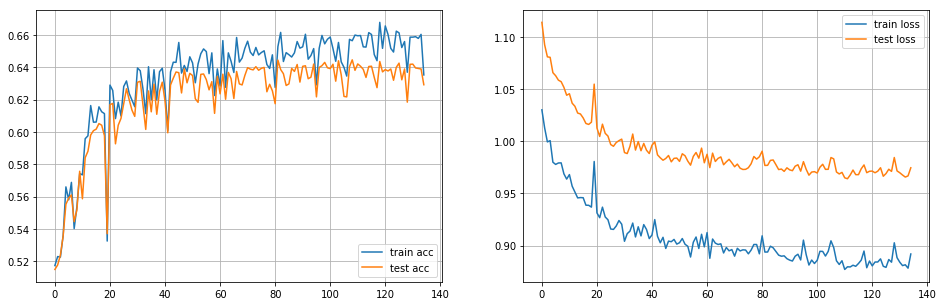

Batch 3382 (865792 samples) complete

KeyboardInterrupt: 

In [70]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  # Comment this out if resuming!
    writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
    writer.add_graph(sess.graph)
    while epochs_completed < n_epochs:

        batch_i += 1
        batch_xs, batch_xrs, batch_xrsls, batch_xchs, batch_xppos, \
            batch_xspell1, batch_xspell2, batch_ycs, batch_yrs = next_batch(batch_size)
        xrs_feed = {xr[i]: batch_xrs[i] for i in N_PL_r}
        xrsls_feed = {xrsl[i]: batch_xrsls[i] for i in N_PL_r}
        ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
        _, s = sess.run([train_step, merged_summary], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
            **{x: batch_xs, x_chmp: batch_xchs, x_ppos: batch_xppos, x_spell1: batch_xspell1, x_spell2: batch_xspell2, \
               keep_prob: dropout_keep_prob, rnn_kp: dropout_rnn}})
        writer.add_summary(s, batch_i)
        sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')

        if batch_i % log_period_batches == 0:
            indices = np.random.choice(n_train, n_train_test, replace=False)
            xrs_feed = {xr[i]: Xr_train[i][indices] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_train[i][indices] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
            train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                   {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                 **{x: X_train[indices], x_chmp: X_champions_train[indices], x_ppos: X_pick_positions_train[indices], \
                    x_spell1: X_spell1s_train[indices], x_spell2: X_spell2s_train[indices], \
                    keep_prob: 1.0, rnn_kp: 1.0}})
            
            xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
            test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                  {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
                   x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
                   keep_prob: 1.0, rnn_kp: 1.0}})
            
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc:
                best_acc = test_a
                best_acc_he = test_he
                best_acc_tr = train_a
                saver.save(sess, "./models/" + model_name + '/' + model_name)

            clear_output()
            print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
                  " Best test acc result:", best_acc_tr, max(test_accuracy), best_acc_he)
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')

            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                    model_name + '_log')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

# Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss)

In [73]:
f2 = lambda l: '_'.join(l.split('_')[:2])
excl_feats_metadata = [l for l in X_labels if "patch__x" in l or "queue__x" in l or "region__x" in l or \
                       l == "time_of_day" or l == "elo"]
incl_is_metadata = np.asarray([i for i in range(len(X_labels)) if X_labels[i] not in excl_feats_metadata]).astype(np.int32)
features_incl_metadata = [l for l in X_labels if l not in excl_feats_metadata]
n_features_incl_metadata = len(features_incl_metadata)
X_mins_metadata = X_mins[incl_is_metadata]
n_features_incl_metadata

829

In [75]:
model_name = "rnn_mt_model_EXCL_metadata"
blue_win_i = Yc_use.index("blue_win")
train_set_test_frac = 0.2 # Get training accuracy for random 20% subset of train set
log_period_batches = 25
n_epochs = 500000
learning_rate_amsgrad = 3.5 * 1e-5
# learning_rate_adam = 3.5 * 1e-5
# learning_rate_gd = 0.01
dropout_keep_prob = 0.67
dropout_rnn = 0.55
batch_size = 256
lstm_forget_bias = 1.0
c_type = "GRU"

pre_rnn1_units = 256
# pre_rnn2_units = 256
# pre_rnn3_units = 256
# pre_rnn_shared_units = 256
n_rnn_units = 256
n_rnn_stacked = 1
post_rnn_units = 256
pre_join_x_units = 4096
l1_n_units = 4096
l2_n_units = 4096
l3_n_units = 4096
l4_n_units = 4096
# l5_n_units = 4096
# l6_n_units = 4096
# final_layer_units = 4096

# Define next batch function
current_i, epochs_completed = 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)
def next_batch(sz):
    global epoch_shuf, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    xs = X_train[batch_idx]
    xrs = [Xr_[batch_idx] for Xr_ in Xr_train]
    xrsls = [Xr_sl_[batch_idx] for Xr_sl_ in Xr_sl_train]
    x_chmps = X_champions_train[batch_idx]
    x_pposs = X_pick_positions_train[batch_idx]
    x_spell1s = X_spell1s_train[batch_idx]
    x_spell2s = X_spell2s_train[batch_idx]
    ycs = [Yc_[batch_idx] for Yc_ in Yc_train]
    yrs = [Yr_[batch_idx] for Yr_ in Yr_train]
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        np.random.shuffle(epoch_shuf)
        epochs_completed += 1
    return xs, xrs, xrsls, x_chmps, x_pposs, x_spell1s, x_spell2s, ycs, yrs

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

def beta_swish(x):
    beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
    return x * tf.nn.sigmoid(beta * x)
def swish(x):
    return x * tf.nn.sigmoid(x)
def autolog(x, x_min, n_feats):
    with tf.name_scope("autolog"):
        alpha = tf.Variable(initial_value=np.tile(0.3, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
        beta = tf.Variable(initial_value=np.tile(0.6, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
        gamma = tf.Variable(initial_value=np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
        act = (alpha * x) + \
            tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
        tf.summary.histogram("autolog_alpha", alpha)
        tf.summary.histogram("autolog_beta", beta)
        tf.summary.histogram("autolog_gamma", gamma)
        tf.summary.histogram("autolog_activation", act)
        return act

x = tf.placeholder(tf.float32, [None, n_features], name='x')
xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name="x_rnn_" + r) for r in t_roles]
xrsl = [tf.placeholder(tf.int32, [None], name="rnn_sequenceLengths_" + r) for r in t_roles]
x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name="labels_" + Yc_use[i]) for i in range(len(Yc_targets))]
yr = [tf.placeholder(tf.float32, [None, 1], name="targets_" + Yr_use[i]) for i in range(len(Yr_targets))]
keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

# n_input_feats = n_features_incl_metadata
n_input_feats = n_features_incl_metadata + (n_champions * 2) + (N_PL ** 2) + (n_spells * N_PL)

def bnorm_appl(inp):
    return dropout(bnorm(inp), keep_prob)

with tf.name_scope("metadata_gather"):
    b_size = tf.shape(x)[0]
    x_eloreg = tf.gather(x, X_eloreg_idx, axis=1)

with tf.name_scope("recurrent"):
    # Construct pre-rnn layers
    with tf.name_scope("pre_rnn_input"):
        xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
        xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), Xr_mins[i], n_rec_features) for i in N_PL_r]
    with tf.name_scope("pre_rnn_fc"):
        Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
        Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
        # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
        # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
        # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
        # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
        # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
        # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

        pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] for i in N_PL_r]
        # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
        pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) for i in N_PL_r]

    with tf.name_scope("rnn_layers"):
        def get_rnn_cell(c_type, lstm_forget_bias, kp):
          cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
                 rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell")
          return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
        if n_rnn_stacked > 1:
        #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
            cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
        else:
        #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
            cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)
        
        with tf.name_scope("rnn_beginToken_W"):
            # W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
            W_begin_token = [tf.Variable(izer([len(X_eloreg_idx), n_rnn_units]), name=r) for r in roles_all]
        with tf.name_scope("rnn_beginToken_b"):
            b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

        # Define rnn cell initial state
        init_states = [tf.matmul(x_eloreg, W_begin_token[i]) + b_begin_token[i] for i in range(5)]
        # init_states = [tf.tile(W_begin_token[i], [b_size, 1]) for i in range(5)]
        rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i % 5],
                                    dtype=tf.float32) for i in N_PL_r])
        # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
        #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
        #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
        rnn_outs = [tf.gather_nd(rnn_os[i], tf.stack([tf.range(b_size), xrsl[i] - 1], axis=1)) for i in N_PL_r]

    with tf.name_scope("post_rnn_fc"):
        Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
        # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

        post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) for i in N_PL_r]
        rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

with tf.name_scope("fully_connected"):

    with tf.name_scope("fc_input"):
        # Add champion compositions and pick positions
        x_champsum = tf.one_hot(x_chmp, n_champions)
        x_pposes = tf.one_hot(x_ppos, N_PL)
        x_ch_bsum = tf.reduce_sum(x_champsum[:, :5], axis=1)
        x_ch_rsum = tf.reduce_sum(x_champsum[:, 5:], axis=1)
        x_spellsum = tf.one_hot(x_spell1, n_spells) + tf.one_hot(x_spell2, n_spells)
        x_input = tf.concat([autolog(tf.gather(x, incl_is_metadata, axis=1), X_mins_metadata, n_features_incl_metadata),
                             x_ch_bsum,
                             x_ch_rsum,
                             tf.reshape(x_pposes, [-1, N_PL ** 2]),
                             tf.reshape(x_spellsum, [-1, N_PL * n_spells])], axis=1)

    with tf.name_scope("fc_layers"):
        Wp_1 = tf.Variable(izer([n_input_feats, pre_join_x_units]), name='W_xin_linear')
        bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

        W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
        # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
        b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
        W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
        b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
        W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
        b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
        W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
        b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
        # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
        # b_5 = tf.Variable(izer([l5_n_units]))
        # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
        # b_6 = tf.Variable(izer([l6_n_units]))
        # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
        # b_7 = tf.Variable(izer([n_outputs]))

        pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

        relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum(rnn_l1))  # Sum join
        # relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

        relu_2 = bnorm_appl(tf.matmul(relu_1, W_2) + b_2)
        relu_3 = bnorm_appl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
        relu_4 = bnorm_appl(tf.matmul(relu_3, W_4) + b_4)
        # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
        # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
        # drop_out = dropout(relu_2, keep_prob)
        # y_out = tf.matmul(drop_out, W_3) + b_3
        # y_out = tf.matmul(relu_3, W_4) + b_4
        #   y_prob = tf.nn.softmax(y_out)

    with tf.name_scope("final_output"):
        # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
        # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

        with tf.name_scope("output_W"):
            Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
            Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
        with tf.name_scope("output_b"):
            Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
            Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

        # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
        # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
        # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
        # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

        with tf.name_scope("classif_outs"):
            Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
        with tf.name_scope("regr_outs"):
            Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

# Define loss function & training step
with tf.name_scope("loss"):
    Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                 labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
    Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
    # loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
    loss = sum(Yc_losses) + (5.0 * (10**-5) * tf.reduce_mean(Yr_losses))

with tf.name_scope("train"):
    train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
    # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)

with tf.name_scope("accuracy"):
    # Define accuracy computation
    correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
    accuracy = tf.reduce_mean(correct)
    accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
merged_summary = tf.summary.merge_all()
    
# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()
create_folder("models")
create_folder("models/" + model_name)
create_folder("model_formats")
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")
save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False)

Epoch 18 : 0.72807145 0.7046723 0.67568696 loss: 0.8063238 0.90110004  Best test acc result: 0.7242143 0.7082793 0.6706911


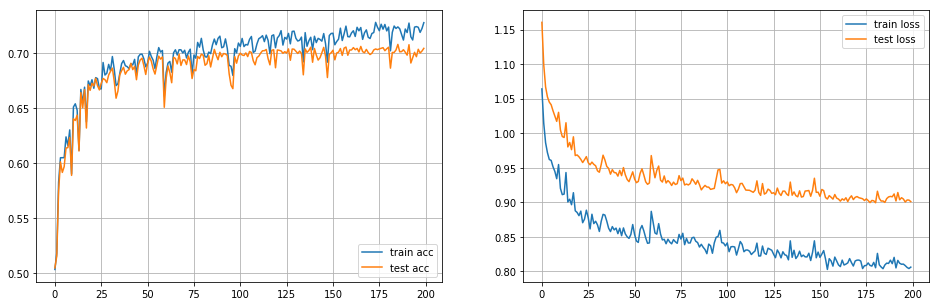

Batch 5014 (1283584 samples) complete

KeyboardInterrupt: 

In [76]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  # Comment this out if resuming!
    writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
    writer.add_graph(sess.graph)
    while epochs_completed < n_epochs:

        batch_i += 1
        batch_xs, batch_xrs, batch_xrsls, batch_xchs, batch_xppos, \
            batch_xspell1, batch_xspell2, batch_ycs, batch_yrs = next_batch(batch_size)
        xrs_feed = {xr[i]: batch_xrs[i] for i in N_PL_r}
        xrsls_feed = {xrsl[i]: batch_xrsls[i] for i in N_PL_r}
        ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
        _, s = sess.run([train_step, merged_summary], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
            **{x: batch_xs, x_chmp: batch_xchs, x_ppos: batch_xppos, x_spell1: batch_xspell1, x_spell2: batch_xspell2, \
               keep_prob: dropout_keep_prob, rnn_kp: dropout_rnn}})
        writer.add_summary(s, batch_i)
        sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')

        if batch_i % log_period_batches == 0:
            indices = np.random.choice(n_train, n_train_test, replace=False)
            xrs_feed = {xr[i]: Xr_train[i][indices] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_train[i][indices] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
            train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                   {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                 **{x: X_train[indices], x_chmp: X_champions_train[indices], x_ppos: X_pick_positions_train[indices], \
                    x_spell1: X_spell1s_train[indices], x_spell2: X_spell2s_train[indices], \
                    keep_prob: 1.0, rnn_kp: 1.0}})
            
            xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
            test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                  {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
                   x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
                   keep_prob: 1.0, rnn_kp: 1.0}})
            
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc:
                best_acc = test_a
                best_acc_he = test_he
                best_acc_tr = train_a
                saver.save(sess, "./models/" + model_name + '/' + model_name)

            clear_output()
            print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
                  " Best test acc result:", best_acc_tr, max(test_accuracy), best_acc_he)
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')

            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                    model_name + '_log')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

# Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss)

In [77]:
f2 = lambda l: '_'.join(l.split('_')[:2])
excl_feats_comp = [l for l in X_labels if \
    ("_recent_" in l and "_/_" not in l) or \
    ("_eloavg_" in l and "_/_" not in l) ]
incl_is_comp = np.asarray([i for i in range(len(X_labels)) if X_labels[i] not in excl_feats_comp]).astype(np.int32)
features_incl_comp = [l for l in X_labels if l not in excl_feats_comp]
n_features_incl_comp = len(features_incl_comp)
X_mins_comp = X_mins[incl_is_comp]
n_features_incl_comp

312

In [82]:
model_name = "rnn_mt_model_EXCL_comp"
blue_win_i = Yc_use.index("blue_win")
train_set_test_frac = 0.2 # Get training accuracy for random 20% subset of train set
log_period_batches = 25
n_epochs = 500000
learning_rate_amsgrad = 3.5 * 1e-5
# learning_rate_adam = 3.5 * 1e-5
# learning_rate_gd = 0.01
dropout_keep_prob = 0.67
dropout_rnn = 0.55
batch_size = 256
lstm_forget_bias = 1.0
c_type = "GRU"

pre_rnn1_units = 256
# pre_rnn2_units = 256
# pre_rnn3_units = 256
# pre_rnn_shared_units = 256
n_rnn_units = 256
n_rnn_stacked = 1
post_rnn_units = 256
pre_join_x_units = 4096
l1_n_units = 4096
l2_n_units = 4096
l3_n_units = 4096
l4_n_units = 4096
# l5_n_units = 4096
# l6_n_units = 4096
# final_layer_units = 4096

# Define next batch function
current_i, epochs_completed = 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)
def next_batch(sz):
    global epoch_shuf, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    xs = X_train[batch_idx]
    xrs = [Xr_[batch_idx] for Xr_ in Xr_train]
    xrsls = [Xr_sl_[batch_idx] for Xr_sl_ in Xr_sl_train]
    x_chmps = X_champions_train[batch_idx]
    x_pposs = X_pick_positions_train[batch_idx]
    x_spell1s = X_spell1s_train[batch_idx]
    x_spell2s = X_spell2s_train[batch_idx]
    ycs = [Yc_[batch_idx] for Yc_ in Yc_train]
    yrs = [Yr_[batch_idx] for Yr_ in Yr_train]
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        np.random.shuffle(epoch_shuf)
        epochs_completed += 1
    return xs, xrs, xrsls, x_chmps, x_pposs, x_spell1s, x_spell2s, ycs, yrs

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

def beta_swish(x):
    beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
    return x * tf.nn.sigmoid(beta * x)
def swish(x):
    return x * tf.nn.sigmoid(x)
def autolog(x, x_min, n_feats):
    with tf.name_scope("autolog"):
        alpha = tf.Variable(initial_value=np.tile(0.3, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
        beta = tf.Variable(initial_value=np.tile(0.6, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
        gamma = tf.Variable(initial_value=np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
        act = (alpha * x) + \
            tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
        tf.summary.histogram("autolog_alpha", alpha)
        tf.summary.histogram("autolog_beta", beta)
        tf.summary.histogram("autolog_gamma", gamma)
        tf.summary.histogram("autolog_activation", act)
        return act

x = tf.placeholder(tf.float32, [None, n_features], name='x')
xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name="x_rnn_" + r) for r in t_roles]
xrsl = [tf.placeholder(tf.int32, [None], name="rnn_sequenceLengths_" + r) for r in t_roles]
x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name="labels_" + Yc_use[i]) for i in range(len(Yc_targets))]
yr = [tf.placeholder(tf.float32, [None, 1], name="targets_" + Yr_use[i]) for i in range(len(Yr_targets))]
keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

n_input_feats = n_features_incl_comp
# n_input_feats = n_features_incl_comp + (n_champions * 2) + (N_PL ** 2) + (n_spells * N_PL)

def bnorm_appl(inp):
    return dropout(bnorm(inp), keep_prob)

with tf.name_scope("get_metadata"):
#     b_size = tf.shape(x)[0]
    x_eloreg = tf.gather(x, X_eloreg_idx, axis=1)

with tf.name_scope("recurrent"):
    # Construct pre-rnn layers
    with tf.name_scope("pre_rnn_input"):
        xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
        xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), Xr_mins[i], n_rec_features) for i in N_PL_r]
    with tf.name_scope("pre_rnn_fc"):
        Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
        Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
        # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
        # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
        # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
        # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
        # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
        # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

        pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] for i in N_PL_r]
        # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
        pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) for i in N_PL_r]

    with tf.name_scope("rnn_layers"):
        def get_rnn_cell(c_type, lstm_forget_bias, kp):
          cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
                 rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell")
          return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
        if n_rnn_stacked > 1:
        #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
            cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
        else:
        #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
            cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)
        
        with tf.name_scope("rnn_beginToken_W"):
            # W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
            W_begin_token = [tf.Variable(izer([len(X_eloreg_idx), n_rnn_units]), name=r) for r in roles_all]
        with tf.name_scope("rnn_beginToken_b"):
            b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

        # Define rnn cell initial state
        init_states = [tf.matmul(x_eloreg, W_begin_token[i]) + b_begin_token[i] for i in range(5)]
        # init_states = [tf.tile(W_begin_token[i], [b_size, 1]) for i in range(5)]
        rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i % 5],
                                    dtype=tf.float32) for i in N_PL_r])
        # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
        #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
        #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
        rnn_outs = [tf.gather_nd(rnn_os[i], tf.stack([tf.range(tf.shape(rnn_os[i])[0]), xrsl[i] - 1], axis=1)) for i in N_PL_r]

    with tf.name_scope("post_rnn_fc"):
        Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
        # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

        post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) for i in N_PL_r]
        rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

with tf.name_scope("fully_connected"):

    with tf.name_scope("fc_input"):
        # Add champion compositions and pick positions
#         x_champsum = tf.one_hot(x_chmp, n_champions)
#         x_pposes = tf.one_hot(x_ppos, N_PL)
#         x_ch_bsum = tf.reduce_sum(x_champsum[:, :5], axis=1)
#         x_ch_rsum = tf.reduce_sum(x_champsum[:, 5:], axis=1)
#         x_spellsum = tf.one_hot(x_spell1, n_spells) + tf.one_hot(x_spell2, n_spells)
#         x_input = tf.concat([autolog(tf.gather(x, incl_is_comp, axis=1), X_mins_comp, n_features_incl_comp),
#                              x_ch_bsum,
#                              x_ch_rsum,
#                              tf.reshape(x_pposes, [-1, N_PL ** 2]),
#                              tf.reshape(x_spellsum, [-1, N_PL * n_spells])], axis=1)
        x_input = autolog(tf.gather(x, incl_is_comp, axis=1), X_mins_comp, n_features_incl_comp)

    with tf.name_scope("fc_layers"):
        Wp_1 = tf.Variable(izer([n_input_feats, pre_join_x_units]), name='W_xin_linear')
        bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

        W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
        # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
        b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
        W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
        b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
        W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
        b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
        W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
        b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
        # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
        # b_5 = tf.Variable(izer([l5_n_units]))
        # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
        # b_6 = tf.Variable(izer([l6_n_units]))
        # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
        # b_7 = tf.Variable(izer([n_outputs]))

        pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

        relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum(rnn_l1))  # Sum join
        # relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

        relu_2 = bnorm_appl(tf.matmul(relu_1, W_2) + b_2)
        relu_3 = bnorm_appl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
        relu_4 = bnorm_appl(tf.matmul(relu_3, W_4) + b_4)
        # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
        # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
        # drop_out = dropout(relu_2, keep_prob)
        # y_out = tf.matmul(drop_out, W_3) + b_3
        # y_out = tf.matmul(relu_3, W_4) + b_4
        #   y_prob = tf.nn.softmax(y_out)

    with tf.name_scope("final_output"):
        # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
        # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

        with tf.name_scope("output_W"):
            Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
            Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
        with tf.name_scope("output_b"):
            Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
            Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

        # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
        # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
        # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
        # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

        with tf.name_scope("classif_outs"):
            Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
        with tf.name_scope("regr_outs"):
            Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

# Define loss function & training step
with tf.name_scope("loss"):
    Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                 labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
    Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
    # loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
    loss = sum(Yc_losses) + (5.0 * (10**-5) * tf.reduce_mean(Yr_losses))

with tf.name_scope("train"):
    train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
    # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)

with tf.name_scope("accuracy"):
    # Define accuracy computation
    correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
    accuracy = tf.reduce_mean(correct)
    accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
merged_summary = tf.summary.merge_all()
    
# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()
create_folder("models")
create_folder("models/" + model_name)
create_folder("model_formats")
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")
save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False)

Epoch 24 : 0.67914283 0.6694471 0.6261449 loss: 0.871706 0.9574691  Best test acc result: 0.6857857 0.68624246 0.6602831


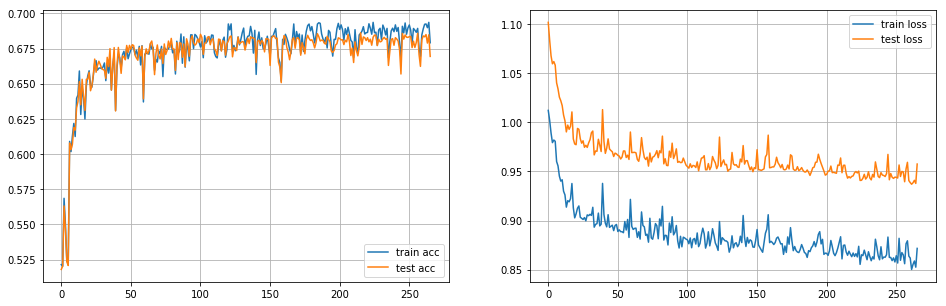

Batch 6652 (1702912 samples) complete

KeyboardInterrupt: 

In [83]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  # Comment this out if resuming!
    writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
    writer.add_graph(sess.graph)
    while epochs_completed < n_epochs:

        batch_i += 1
        batch_xs, batch_xrs, batch_xrsls, batch_xchs, batch_xppos, \
            batch_xspell1, batch_xspell2, batch_ycs, batch_yrs = next_batch(batch_size)
        xrs_feed = {xr[i]: batch_xrs[i] for i in N_PL_r}
        xrsls_feed = {xrsl[i]: batch_xrsls[i] for i in N_PL_r}
        ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
        _, s = sess.run([train_step, merged_summary], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
            **{x: batch_xs, x_chmp: batch_xchs, x_ppos: batch_xppos, x_spell1: batch_xspell1, x_spell2: batch_xspell2, \
               keep_prob: dropout_keep_prob, rnn_kp: dropout_rnn}})
        writer.add_summary(s, batch_i)
        sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')

        if batch_i % log_period_batches == 0:
            indices = np.random.choice(n_train, n_train_test, replace=False)
            xrs_feed = {xr[i]: Xr_train[i][indices] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_train[i][indices] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
            train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                   {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                 **{x: X_train[indices], x_chmp: X_champions_train[indices], x_ppos: X_pick_positions_train[indices], \
                    x_spell1: X_spell1s_train[indices], x_spell2: X_spell2s_train[indices], \
                    keep_prob: 1.0, rnn_kp: 1.0}})
            
            xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
            test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                  {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
                   x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
                   keep_prob: 1.0, rnn_kp: 1.0}})
            
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc:
                best_acc = test_a
                best_acc_he = test_he
                best_acc_tr = train_a
                saver.save(sess, "./models/" + model_name + '/' + model_name)

            clear_output()
            print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
                  " Best test acc result:", best_acc_tr, max(test_accuracy), best_acc_he)
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')

            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                    model_name + '_log')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

# Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss)

In [77]:
# f2 = lambda l: '_'.join(l.split('_')[:2])
# excl_feats_categoricals = []
# incl_is_categoricals = np.asarray([i for i in range(len(X_labels)) if X_labels[i] not in excl_feats_categoricals]).astype(np.int32)
# features_incl_categoricals = [l for l in X_labels if l not in excl_feats_categoricals]
# n_features_incl_categoricals = len(features_incl_categoricals)
# X_mins_categoricals = X_mins[incl_is_categoricals]
# n_features_incl_categoricals

312

In [84]:
model_name = "rnn_mt_model_EXCL_categoricals"
blue_win_i = Yc_use.index("blue_win")
train_set_test_frac = 0.2 # Get training accuracy for random 20% subset of train set
log_period_batches = 25
n_epochs = 500000
learning_rate_amsgrad = 3.5 * 1e-5
# learning_rate_adam = 3.5 * 1e-5
# learning_rate_gd = 0.01
dropout_keep_prob = 0.67
dropout_rnn = 0.55
batch_size = 256
lstm_forget_bias = 1.0
c_type = "GRU"

pre_rnn1_units = 256
# pre_rnn2_units = 256
# pre_rnn3_units = 256
# pre_rnn_shared_units = 256
n_rnn_units = 256
n_rnn_stacked = 1
post_rnn_units = 256
pre_join_x_units = 4096
l1_n_units = 4096
l2_n_units = 4096
l3_n_units = 4096
l4_n_units = 4096
# l5_n_units = 4096
# l6_n_units = 4096
# final_layer_units = 4096

# Define next batch function
current_i, epochs_completed = 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)
def next_batch(sz):
    global epoch_shuf, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    xs = X_train[batch_idx]
    xrs = [Xr_[batch_idx] for Xr_ in Xr_train]
    xrsls = [Xr_sl_[batch_idx] for Xr_sl_ in Xr_sl_train]
    x_chmps = X_champions_train[batch_idx]
    x_pposs = X_pick_positions_train[batch_idx]
    x_spell1s = X_spell1s_train[batch_idx]
    x_spell2s = X_spell2s_train[batch_idx]
    ycs = [Yc_[batch_idx] for Yc_ in Yc_train]
    yrs = [Yr_[batch_idx] for Yr_ in Yr_train]
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        np.random.shuffle(epoch_shuf)
        epochs_completed += 1
    return xs, xrs, xrsls, x_chmps, x_pposs, x_spell1s, x_spell2s, ycs, yrs

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

def beta_swish(x):
    beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
    return x * tf.nn.sigmoid(beta * x)
def swish(x):
    return x * tf.nn.sigmoid(x)
def autolog(x, x_min, n_feats):
    with tf.name_scope("autolog"):
        alpha = tf.Variable(initial_value=np.tile(0.3, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
        beta = tf.Variable(initial_value=np.tile(0.6, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
        gamma = tf.Variable(initial_value=np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
        act = (alpha * x) + \
            tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
        tf.summary.histogram("autolog_alpha", alpha)
        tf.summary.histogram("autolog_beta", beta)
        tf.summary.histogram("autolog_gamma", gamma)
        tf.summary.histogram("autolog_activation", act)
        return act

x = tf.placeholder(tf.float32, [None, n_features], name='x')
xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name="x_rnn_" + r) for r in t_roles]
xrsl = [tf.placeholder(tf.int32, [None], name="rnn_sequenceLengths_" + r) for r in t_roles]
x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name="labels_" + Yc_use[i]) for i in range(len(Yc_targets))]
yr = [tf.placeholder(tf.float32, [None, 1], name="targets_" + Yr_use[i]) for i in range(len(Yr_targets))]
keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

n_input_feats = n_features
# n_input_feats = n_features + (n_champions * 2) + (N_PL ** 2) + (n_spells * N_PL)

def bnorm_appl(inp):
    return dropout(bnorm(inp), keep_prob)

with tf.name_scope("get_metadata"):
#     b_size = tf.shape(x)[0]
    x_eloreg = tf.gather(x, X_eloreg_idx, axis=1)

with tf.name_scope("recurrent"):
    # Construct pre-rnn layers
    with tf.name_scope("pre_rnn_input"):
        xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
        xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), Xr_mins[i], n_rec_features) for i in N_PL_r]
    with tf.name_scope("pre_rnn_fc"):
        Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
        Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
        # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
        # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
        # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
        # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
        # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
        # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

        pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] for i in N_PL_r]
        # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
        pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) for i in N_PL_r]

    with tf.name_scope("rnn_layers"):
        def get_rnn_cell(c_type, lstm_forget_bias, kp):
          cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
                 rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell")
          return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
        if n_rnn_stacked > 1:
        #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
            cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
        else:
        #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
            cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)
        
        with tf.name_scope("rnn_beginToken_W"):
            # W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
            W_begin_token = [tf.Variable(izer([len(X_eloreg_idx), n_rnn_units]), name=r) for r in roles_all]
        with tf.name_scope("rnn_beginToken_b"):
            b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

        # Define rnn cell initial state
        init_states = [tf.matmul(x_eloreg, W_begin_token[i]) + b_begin_token[i] for i in range(5)]
        # init_states = [tf.tile(W_begin_token[i], [b_size, 1]) for i in range(5)]
        rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i % 5],
                                    dtype=tf.float32) for i in N_PL_r])
        # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
        #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
        #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
        rnn_outs = [tf.gather_nd(rnn_os[i], tf.stack([tf.range(tf.shape(rnn_os[i])[0]), xrsl[i] - 1], axis=1)) for i in N_PL_r]

    with tf.name_scope("post_rnn_fc"):
        Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
        # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

        post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) for i in N_PL_r]
        rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

with tf.name_scope("fully_connected"):

    with tf.name_scope("fc_input"):
        # Add champion compositions and pick positions
#         x_champsum = tf.one_hot(x_chmp, n_champions)
#         x_pposes = tf.one_hot(x_ppos, N_PL)
#         x_ch_bsum = tf.reduce_sum(x_champsum[:, :5], axis=1)
#         x_ch_rsum = tf.reduce_sum(x_champsum[:, 5:], axis=1)
#         x_spellsum = tf.one_hot(x_spell1, n_spells) + tf.one_hot(x_spell2, n_spells)
#         x_input = tf.concat([autolog(x, X_mins, n_features_incl),
#                              x_ch_bsum,
#                              x_ch_rsum,
#                              tf.reshape(x_pposes, [-1, N_PL ** 2]),
#                              tf.reshape(x_spellsum, [-1, N_PL * n_spells])], axis=1)
        x_input = autolog(x, X_mins, n_features)

    with tf.name_scope("fc_layers"):
        Wp_1 = tf.Variable(izer([n_input_feats, pre_join_x_units]), name='W_xin_linear')
        bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

        W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
        # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
        b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
        W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
        b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
        W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
        b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
        W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
        b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
        # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
        # b_5 = tf.Variable(izer([l5_n_units]))
        # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
        # b_6 = tf.Variable(izer([l6_n_units]))
        # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
        # b_7 = tf.Variable(izer([n_outputs]))

        pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

        relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum(rnn_l1))  # Sum join
        # relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

        relu_2 = bnorm_appl(tf.matmul(relu_1, W_2) + b_2)
        relu_3 = bnorm_appl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
        relu_4 = bnorm_appl(tf.matmul(relu_3, W_4) + b_4)
        # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
        # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
        # drop_out = dropout(relu_2, keep_prob)
        # y_out = tf.matmul(drop_out, W_3) + b_3
        # y_out = tf.matmul(relu_3, W_4) + b_4
        #   y_prob = tf.nn.softmax(y_out)

    with tf.name_scope("final_output"):
        # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
        # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

        with tf.name_scope("output_W"):
            Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
            Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
        with tf.name_scope("output_b"):
            Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
            Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

        # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
        # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
        # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
        # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

        with tf.name_scope("classif_outs"):
            Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
        with tf.name_scope("regr_outs"):
            Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

# Define loss function & training step
with tf.name_scope("loss"):
    Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                 labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
    Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
    # loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
    loss = sum(Yc_losses) + (5.0 * (10**-5) * tf.reduce_mean(Yr_losses))

with tf.name_scope("train"):
    train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
    # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)

with tf.name_scope("accuracy"):
    # Define accuracy computation
    correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
    accuracy = tf.reduce_mean(correct)
    accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
merged_summary = tf.summary.merge_all()
    
# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()
create_folder("models")
create_folder("models/" + model_name)
create_folder("model_formats")
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")
save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False)

Epoch 39 : 0.784 0.6919348 0.6636137 loss: 0.69772756 0.906473  Best test acc result: 0.71428573 0.7080539 0.6777685


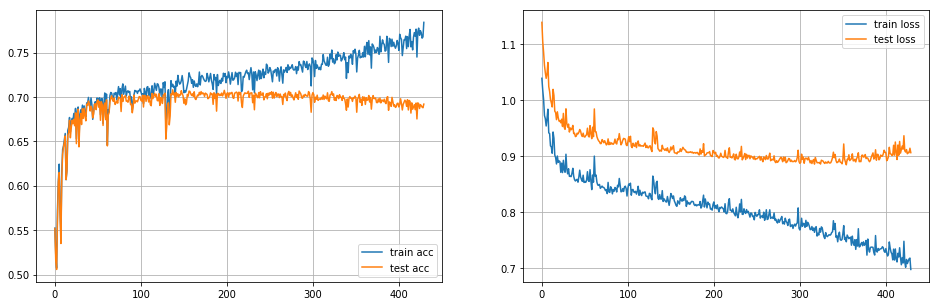

Batch 10760 (2754560 samples) complete

KeyboardInterrupt: 

In [85]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  # Comment this out if resuming!
    writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
    writer.add_graph(sess.graph)
    while epochs_completed < n_epochs:

        batch_i += 1
        batch_xs, batch_xrs, batch_xrsls, batch_xchs, batch_xppos, \
            batch_xspell1, batch_xspell2, batch_ycs, batch_yrs = next_batch(batch_size)
        xrs_feed = {xr[i]: batch_xrs[i] for i in N_PL_r}
        xrsls_feed = {xrsl[i]: batch_xrsls[i] for i in N_PL_r}
        ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
        _, s = sess.run([train_step, merged_summary], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
            **{x: batch_xs, x_chmp: batch_xchs, x_ppos: batch_xppos, x_spell1: batch_xspell1, x_spell2: batch_xspell2, \
               keep_prob: dropout_keep_prob, rnn_kp: dropout_rnn}})
        writer.add_summary(s, batch_i)
        sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')

        if batch_i % log_period_batches == 0:
            indices = np.random.choice(n_train, n_train_test, replace=False)
            xrs_feed = {xr[i]: Xr_train[i][indices] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_train[i][indices] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
            train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                   {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                 **{x: X_train[indices], x_chmp: X_champions_train[indices], x_ppos: X_pick_positions_train[indices], \
                    x_spell1: X_spell1s_train[indices], x_spell2: X_spell2s_train[indices], \
                    keep_prob: 1.0, rnn_kp: 1.0}})
            
            xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
            test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                  {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
                   x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
                   keep_prob: 1.0, rnn_kp: 1.0}})
            
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc:
                best_acc = test_a
                best_acc_he = test_he
                best_acc_tr = train_a
                saver.save(sess, "./models/" + model_name + '/' + model_name)

            clear_output()
            print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
                  " Best test acc result:", best_acc_tr, max(test_accuracy), best_acc_he)
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')

            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                    model_name + '_log')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

# Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss)

In [93]:
f2 = lambda l: '_'.join(l.split('_')[:2])
excl_feats_globs = [l for l in X_labels if "_eloavg_" in l and "_/_" not in l and "_matchup_" in l ]
incl_is_globs = np.asarray([i for i in range(len(X_labels)) if X_labels[i] not in excl_feats_globs]).astype(np.int32)
features_incl_globs = [l for l in X_labels if l not in excl_feats_globs]
n_features_incl_globs = len(features_incl_globs)
X_mins_globs = X_mins[incl_is_globs]
n_features_incl_globs

672

In [96]:
model_name = "rnn_mt_model_EXCL_globs_matchups"
blue_win_i = Yc_use.index("blue_win")
train_set_test_frac = 0.2 # Get training accuracy for random 20% subset of train set
log_period_batches = 25
n_epochs = 500000
learning_rate_amsgrad = 3.5 * 1e-5
# learning_rate_adam = 3.5 * 1e-5
# learning_rate_gd = 0.01
dropout_keep_prob = 0.67
dropout_rnn = 0.55
batch_size = 256
lstm_forget_bias = 1.0
c_type = "GRU"

pre_rnn1_units = 256
# pre_rnn2_units = 256
# pre_rnn3_units = 256
# pre_rnn_shared_units = 256
n_rnn_units = 256
n_rnn_stacked = 1
post_rnn_units = 256
pre_join_x_units = 4096
l1_n_units = 4096
l2_n_units = 4096
l3_n_units = 4096
l4_n_units = 4096
# l5_n_units = 4096
# l6_n_units = 4096
# final_layer_units = 4096

# Define next batch function
current_i, epochs_completed = 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)
def next_batch(sz):
    global epoch_shuf, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    xs = X_train[batch_idx]
    xrs = [Xr_[batch_idx] for Xr_ in Xr_train]
    xrsls = [Xr_sl_[batch_idx] for Xr_sl_ in Xr_sl_train]
    x_chmps = X_champions_train[batch_idx]
    x_pposs = X_pick_positions_train[batch_idx]
    x_spell1s = X_spell1s_train[batch_idx]
    x_spell2s = X_spell2s_train[batch_idx]
    ycs = [Yc_[batch_idx] for Yc_ in Yc_train]
    yrs = [Yr_[batch_idx] for Yr_ in Yr_train]
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        np.random.shuffle(epoch_shuf)
        epochs_completed += 1
    return xs, xrs, xrsls, x_chmps, x_pposs, x_spell1s, x_spell2s, ycs, yrs

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

def beta_swish(x):
    beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
    return x * tf.nn.sigmoid(beta * x)
def swish(x):
    return x * tf.nn.sigmoid(x)
def autolog(x, x_min, n_feats):
    with tf.name_scope("autolog"):
        alpha = tf.Variable(initial_value=np.tile(0.3, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
        beta = tf.Variable(initial_value=np.tile(0.6, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
        gamma = tf.Variable(initial_value=np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
        act = (alpha * x) + \
            tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
        tf.summary.histogram("autolog_alpha", alpha)
        tf.summary.histogram("autolog_beta", beta)
        tf.summary.histogram("autolog_gamma", gamma)
        tf.summary.histogram("autolog_activation", act)
        return act

x = tf.placeholder(tf.float32, [None, n_features], name='x')
xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name=r + "_x_rnn") for r in t_roles]
xrsl = [tf.placeholder(tf.int32, [None], name="rnn_sequenceLengths_" + r) for r in t_roles]
x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name=Yc_use[i] + "_label") for i in range(len(Yc_targets))]
yr = [tf.placeholder(tf.float32, [None, 1], name=Yr_use[i] + "_target") for i in range(len(Yr_targets))]
keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

# n_input_feats = n_features_incl_globs
n_input_feats = n_features_incl_globs + (n_champions * 2) + (N_PL ** 2) + (n_spells * N_PL)

def bnorm_appl(inp):
    return dropout(bnorm(inp), keep_prob)

with tf.name_scope("get_metadata"):
#     b_size = tf.shape(x)[0]
    x_eloreg = tf.gather(x, X_eloreg_idx, axis=1)

with tf.name_scope("recurrent"):
    # Construct pre-rnn layers
    with tf.name_scope("pre_rnn_input"):
        xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
        xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), Xr_mins[i], n_rec_features) for i in N_PL_r]
    with tf.name_scope("pre_rnn_fc"):
        Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
        Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
        # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
        # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
        # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
        # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
        # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
        # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

        pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] for i in N_PL_r]
        # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
        pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) for i in N_PL_r]

    with tf.name_scope("rnn_layers"):
        def get_rnn_cell(c_type, lstm_forget_bias, kp):
          cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
                 rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell")
          return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
        if n_rnn_stacked > 1:
        #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
            cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
        else:
        #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
            cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)
        
        with tf.name_scope("rnn_beginToken_W"):
            # W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
            W_begin_token = [tf.Variable(izer([len(X_eloreg_idx), n_rnn_units]), name=r) for r in roles_all]
        with tf.name_scope("rnn_beginToken_b"):
            b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

        # Define rnn cell initial state
        init_states = [tf.matmul(x_eloreg, W_begin_token[i]) + b_begin_token[i] for i in range(5)]
        # init_states = [tf.tile(W_begin_token[i], [b_size, 1]) for i in range(5)]
        rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i % 5],
                                    dtype=tf.float32) for i in N_PL_r])
        # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
        #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
        #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
        rnn_outs = [tf.gather_nd(rnn_os[i], tf.stack([tf.range(tf.shape(rnn_os[i])[0]), xrsl[i] - 1], axis=1)) for i in N_PL_r]

    with tf.name_scope("post_rnn_fc"):
        Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
        # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

        post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) for i in N_PL_r]
        rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

with tf.name_scope("fully_connected"):

    with tf.name_scope("fc_input"):
        # Add champion compositions and pick positions
        x_champsum = tf.one_hot(x_chmp, n_champions)
        x_pposes = tf.one_hot(x_ppos, N_PL)
        x_ch_bsum = tf.reduce_sum(x_champsum[:, :5], axis=1)
        x_ch_rsum = tf.reduce_sum(x_champsum[:, 5:], axis=1)
        x_spellsum = tf.one_hot(x_spell1, n_spells) + tf.one_hot(x_spell2, n_spells)
        x_input = tf.concat([autolog(tf.gather(x, incl_is_globs, axis=1), X_mins_globs, n_features_incl_globs),
                             x_ch_bsum,
                             x_ch_rsum,
                             tf.reshape(x_pposes, [-1, N_PL ** 2]),
                             tf.reshape(x_spellsum, [-1, N_PL * n_spells])], axis=1)

    with tf.name_scope("fc_layers"):
        Wp_1 = tf.Variable(izer([n_input_feats, pre_join_x_units]), name='W_xin_linear')
        bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

        W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
        # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
        b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
        W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
        b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
        W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
        b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
        W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
        b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
        # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
        # b_5 = tf.Variable(izer([l5_n_units]))
        # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
        # b_6 = tf.Variable(izer([l6_n_units]))
        # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
        # b_7 = tf.Variable(izer([n_outputs]))

        pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

        relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum(rnn_l1))  # Sum join
        # relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

        relu_2 = bnorm_appl(tf.matmul(relu_1, W_2) + b_2)
        relu_3 = bnorm_appl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
        relu_4 = bnorm_appl(tf.matmul(relu_3, W_4) + b_4)
        # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
        # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
        # drop_out = dropout(relu_2, keep_prob)
        # y_out = tf.matmul(drop_out, W_3) + b_3
        # y_out = tf.matmul(relu_3, W_4) + b_4
        #   y_prob = tf.nn.softmax(y_out)

    with tf.name_scope("final_output"):
        # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
        # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

        with tf.name_scope("output_W"):
            Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
            Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
        with tf.name_scope("output_b"):
            Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
            Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

        # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
        # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
        # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
        # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

        with tf.name_scope("classif_outs"):
            Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
        with tf.name_scope("regr_outs"):
            Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

# Define loss function & training step
with tf.name_scope("loss"):
    Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                 labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
    Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
    # loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
    loss = sum(Yc_losses) + (5.0 * (10**-5) * tf.reduce_mean(Yr_losses))

with tf.name_scope("train"):
    train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
    # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)

with tf.name_scope("accuracy"):
    # Define accuracy computation
    correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
    accuracy = tf.reduce_mean(correct)
    accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
merged_summary = tf.summary.merge_all()
    
# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()
create_folder("models")
create_folder("models/" + model_name)
create_folder("model_formats")
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")
save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False)

Epoch 36 : 0.7584286 0.69948715 0.67152375 loss: 0.7399646 0.897104 Best test acc res: 0.7286429 0.7080539 0.67443794 282


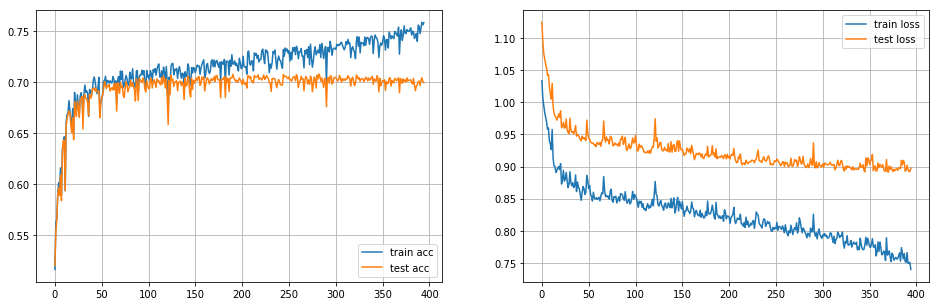

Batch 9878 (2528768 samples) complete

KeyboardInterrupt: 

In [97]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  # Comment this out if resuming!
    writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
    writer.add_graph(sess.graph)
    while epochs_completed < n_epochs:

        batch_i += 1
        batch_xs, batch_xrs, batch_xrsls, batch_xchs, batch_xppos, \
            batch_xspell1, batch_xspell2, batch_ycs, batch_yrs = next_batch(batch_size)
        xrs_feed = {xr[i]: batch_xrs[i] for i in N_PL_r}
        xrsls_feed = {xrsl[i]: batch_xrsls[i] for i in N_PL_r}
        ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
        _, s = sess.run([train_step, merged_summary], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
            **{x: batch_xs, x_chmp: batch_xchs, x_ppos: batch_xppos, x_spell1: batch_xspell1, x_spell2: batch_xspell2, \
               keep_prob: dropout_keep_prob, rnn_kp: dropout_rnn}})
        writer.add_summary(s, batch_i)
        sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')

        if batch_i % log_period_batches == 0:
            indices = np.random.choice(n_train, n_train_test, replace=False)
            xrs_feed = {xr[i]: Xr_train[i][indices] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_train[i][indices] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
            train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                   {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                 **{x: X_train[indices], x_chmp: X_champions_train[indices], x_ppos: X_pick_positions_train[indices], \
                    x_spell1: X_spell1s_train[indices], x_spell2: X_spell2s_train[indices], \
                    keep_prob: 1.0, rnn_kp: 1.0}})
            
            xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
            test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                  {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
                   x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
                   keep_prob: 1.0, rnn_kp: 1.0}})
            
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc:
                best_acc = test_a
                best_acc_he = test_he
                best_acc_tr = train_a
                saver.save(sess, "./models/" + model_name + '/' + model_name)

            clear_output()
            print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
                  "Best test acc res:", best_acc_tr, max(test_accuracy), best_acc_he, np.argmax(test_accuracy))
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')

            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                    model_name + '_log')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

# Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss)

Epoch 51 : 0.716 0.678352 0.6557036 loss: 0.80158925 0.93193066  Best test acc result: 0.69792855 0.6882151 0.65986675


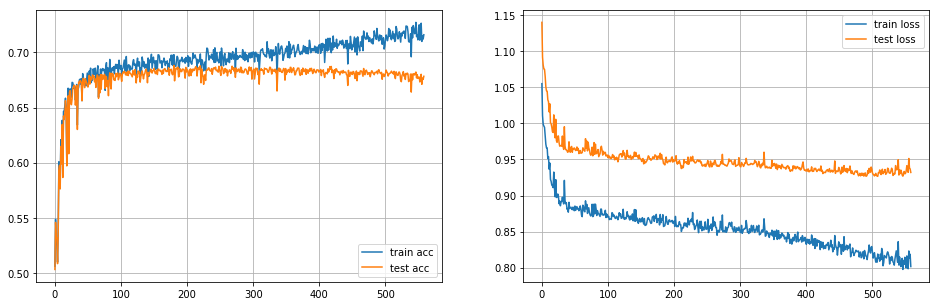

Batch 13979 (3578624 samples) complete

KeyboardInterrupt: 

In [88]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  # Comment this out if resuming!
    writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
    writer.add_graph(sess.graph)
    while epochs_completed < n_epochs:

        batch_i += 1
        batch_xs, batch_xrs, batch_xrsls, batch_xchs, batch_xppos, \
            batch_xspell1, batch_xspell2, batch_ycs, batch_yrs = next_batch(batch_size)
        xrs_feed = {xr[i]: batch_xrs[i] for i in N_PL_r}
        xrsls_feed = {xrsl[i]: batch_xrsls[i] for i in N_PL_r}
        ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
        _, s = sess.run([train_step, merged_summary], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
            **{x: batch_xs, x_chmp: batch_xchs, x_ppos: batch_xppos, x_spell1: batch_xspell1, x_spell2: batch_xspell2, \
               keep_prob: dropout_keep_prob, rnn_kp: dropout_rnn}})
        writer.add_summary(s, batch_i)
        sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')

        if batch_i % log_period_batches == 0:
            indices = np.random.choice(n_train, n_train_test, replace=False)
            xrs_feed = {xr[i]: Xr_train[i][indices] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_train[i][indices] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
            train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                   {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                 **{x: X_train[indices], x_chmp: X_champions_train[indices], x_ppos: X_pick_positions_train[indices], \
                    x_spell1: X_spell1s_train[indices], x_spell2: X_spell2s_train[indices], \
                    keep_prob: 1.0, rnn_kp: 1.0}})
            
            xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
            test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                  {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
                   x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
                   keep_prob: 1.0, rnn_kp: 1.0}})
            
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc:
                best_acc = test_a
                best_acc_he = test_he
                best_acc_tr = train_a
                saver.save(sess, "./models/" + model_name + '/' + model_name)

            clear_output()
            print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
                  " Best test acc result:", best_acc_tr, max(test_accuracy), best_acc_he)
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')

            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                    model_name + '_log')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

# Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss)

In [122]:
def train_MTRNN_excl1role(i_excl):
    global epoch_shuf, current_i, epochs_completed
    
    role_excl = roles_all[i_excl]
    incl_ris = np.asarray([i for i in N_PL_r if i % 5 != i_excl]).astype(np.int32)

    excl_feats_rol = [l for l in X_labels if (f2(l) in t_roles and l.split('_')[1] == role_excl)]
    if role_excl == "adc" or role_excl == "support":
        excl_feats_rol += [l for l in X_labels if "_synergy_" in l or "_adc_support_" in l or "_support_adc_" in l]
    incl_is_rol = np.asarray([i for i in range(len(X_labels)) if X_labels[i] not in excl_feats_rol]).astype(np.int32)
    features_incl_rol = [l for l in X_labels if l not in excl_feats_rol]
    n_features_incl_rol = len(features_incl_rol)
    X_mins_rol = X_mins[incl_is_rol]

    model_name = "rnn_mt_model_EXCL_" + role_excl
    blue_win_i = Yc_use.index("blue_win")
    train_set_test_frac = 0.2 # Get training accuracy for random 20% subset of train set
    log_period_batches = 25
    n_epochs = 30
    learning_rate_amsgrad = 3.5 * 1e-5
    # learning_rate_adam = 3.5 * 1e-5
    # learning_rate_gd = 0.01
    dropout_keep_prob = 0.67
    dropout_rnn = 0.55
    batch_size = 256
    lstm_forget_bias = 1.0
    c_type = "GRU"

    pre_rnn1_units = 256
    # pre_rnn2_units = 256
    # pre_rnn3_units = 256
    # pre_rnn_shared_units = 256
    n_rnn_units = 256
    n_rnn_stacked = 1
    post_rnn_units = 256
    pre_join_x_units = 4096
    l1_n_units = 4096
    l2_n_units = 4096
    l3_n_units = 4096
    l4_n_units = 4096
    # l5_n_units = 4096
    # l6_n_units = 4096
    # final_layer_units = 4096

    # Define next batch function
    current_i, epochs_completed = 0, 0
    epoch_shuf = np.arange(n_train)
    np.random.shuffle(epoch_shuf)
    def next_batch(sz):
        global epoch_shuf, current_i, epochs_completed
        batch_idx = epoch_shuf[current_i:current_i + sz]
        xs = X_train[batch_idx]
        xrs = [Xr_[batch_idx] for Xr_ in Xr_train]
        xrsls = [Xr_sl_[batch_idx] for Xr_sl_ in Xr_sl_train]
        x_chmps = X_champions_train[batch_idx]
        x_pposs = X_pick_positions_train[batch_idx]
        x_spell1s = X_spell1s_train[batch_idx]
        x_spell2s = X_spell2s_train[batch_idx]
        ycs = [Yc_[batch_idx] for Yc_ in Yc_train]
        yrs = [Yr_[batch_idx] for Yr_ in Yr_train]
        current_i += sz
        if current_i >= n_train - 1:
            current_i = 0
            np.random.shuffle(epoch_shuf)
            epochs_completed += 1
        return xs, xrs, xrsls, x_chmps, x_pposs, x_spell1s, x_spell2s, ycs, yrs

    n_train_test = int(train_set_test_frac * n_train)
    izer = tf.contrib.layers.xavier_initializer()
    tf.reset_default_graph()
    train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

    def beta_swish(x):
        beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
        return x * tf.nn.sigmoid(beta * x)
    def swish(x):
        return x * tf.nn.sigmoid(x)
    def autolog(x, x_min, n_feats):
        with tf.name_scope("autolog"):
            alpha = tf.Variable(initial_value=np.tile(0.3, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
            beta = tf.Variable(initial_value=np.tile(0.6, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
            gamma = tf.Variable(initial_value=np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
            act = (alpha * x) + \
                tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
            tf.summary.histogram("autolog_alpha", alpha)
            tf.summary.histogram("autolog_beta", beta)
            tf.summary.histogram("autolog_gamma", gamma)
            tf.summary.histogram("autolog_activation", act)
            return act

    x = tf.placeholder(tf.float32, [None, n_features], name='x')
    xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name=r + "_x_rnn") for r in t_roles]
    xrsl = [tf.placeholder(tf.int32, [None], name="rnn_sequenceLengths_" + r) for r in t_roles]
    x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
    x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
    x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
    x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
    yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name=Yc_use[i] + "_label") for i in range(len(Yc_targets))]
    yr = [tf.placeholder(tf.float32, [None, 1], name=Yr_use[i] + "_target") for i in range(len(Yr_targets))]
    keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
    rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

    # n_input_feats = n_features_incl_rol
    n_input_feats = n_features_incl_rol + (n_champions * 2) + (N_PL * 8) + (n_spells * 8)
    
    x_chmp_ = tf.gather(x_chmp, incl_ris, axis=1)
    x_ppos_ = tf.gather(x_ppos, incl_ris, axis=1)
    x_spell1_ = tf.gather(x_spell1, incl_ris, axis=1)
    x_spell2_ = tf.gather(x_spell2, incl_ris, axis=1)
#     xr = [xr[i] for i in incl_ris]
#     xrsl = [xrsl[i] for i in incl_ris]

    def bnorm_appl(inp):
        return dropout(bnorm(inp), keep_prob)

    with tf.name_scope("get_metadata"):
    #     b_size = tf.shape(x)[0]
        x_eloreg = tf.gather(x, X_eloreg_idx, axis=1)

    with tf.name_scope("recurrent"):
        # Construct pre-rnn layers
        with tf.name_scope("pre_rnn_input"):
            xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
            xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), Xr_mins[i], n_rec_features) if i in incl_ris else None for i in N_PL_r]
        with tf.name_scope("pre_rnn_fc"):
            Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
            Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
            # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
            # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
            # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
            # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
            # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
            # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

            pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] if i in incl_ris else None for i in N_PL_r]
            # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
            # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
            # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
            pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) if i in incl_ris else None for i in N_PL_r]

        with tf.name_scope("rnn_layers"):
            def get_rnn_cell(c_type, lstm_forget_bias, kp):
              cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
                     rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell")
              return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
            if n_rnn_stacked > 1:
            #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
                cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
            else:
            #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
                cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)

            with tf.name_scope("rnn_beginToken_W"):
                # W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
                W_begin_token = [tf.Variable(izer([len(X_eloreg_idx), n_rnn_units]), name=r) for r in roles_all]
            with tf.name_scope("rnn_beginToken_b"):
                b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

            # Define rnn cell initial state
            init_states = [tf.matmul(x_eloreg, W_begin_token[i]) + b_begin_token[i] for i in range(5)]
            # init_states = [tf.tile(W_begin_token[i], [b_size, 1]) for i in range(5)]
            rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i % 5],
                                        dtype=tf.float32) for i in incl_ris])
            # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
            #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
            #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
            rnn_outs = [tf.gather_nd(rnn_os[np.where(incl_ris == i)[0][0]], tf.stack([tf.range(tf.shape(rnn_os[np.where(incl_ris == i)[0][0]])[0]), \
                        xrsl[i] - 1], axis=1)) if i in incl_ris else None for i in N_PL_r]

        with tf.name_scope("post_rnn_fc"):
            Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
            Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
            Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
            # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

            post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) if i in incl_ris else None for i in N_PL_r]
            rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) if i in incl_ris else None for i in N_PL_r]  # Sum join

    with tf.name_scope("fully_connected"):

        with tf.name_scope("fc_input"):
            # Add champion compositions and pick positions
            x_champsum = tf.one_hot(x_chmp_, n_champions)
            x_pposes = tf.one_hot(x_ppos_, N_PL)
            x_ch_bsum = tf.reduce_sum(x_champsum[:, :4], axis=1)
            x_ch_rsum = tf.reduce_sum(x_champsum[:, 4:], axis=1)
            x_spellsum = tf.one_hot(x_spell1_, n_spells) + tf.one_hot(x_spell2_, n_spells)
            x_input = tf.concat([autolog(tf.gather(x, incl_is_rol, axis=1), X_mins_rol, n_features_incl_rol),
                                 x_ch_bsum,
                                 x_ch_rsum,
                                 tf.reshape(x_pposes, [-1, 8 * N_PL]),
                                 tf.reshape(x_spellsum, [-1, 8 * n_spells])], axis=1)

        with tf.name_scope("fc_layers"):
            Wp_1 = tf.Variable(izer([n_input_feats, pre_join_x_units]), name='W_xin_linear')
            bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

            W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
            # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
            b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
            W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
            b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
            W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
            b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
            W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
            b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
            # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
            # b_5 = tf.Variable(izer([l5_n_units]))
            # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
            # b_6 = tf.Variable(izer([l6_n_units]))
            # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
            # b_7 = tf.Variable(izer([n_outputs]))

            pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

            relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum([l_ for l_ in rnn_l1 if l_ is not None]))  # Sum join
            # relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

            relu_2 = bnorm_appl(tf.matmul(relu_1, W_2) + b_2)
            relu_3 = bnorm_appl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
            relu_4 = bnorm_appl(tf.matmul(relu_3, W_4) + b_4)
            # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
            # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
            # drop_out = dropout(relu_2, keep_prob)
            # y_out = tf.matmul(drop_out, W_3) + b_3
            # y_out = tf.matmul(relu_3, W_4) + b_4
            #   y_prob = tf.nn.softmax(y_out)

        with tf.name_scope("final_output"):
            # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
            # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
            # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
            # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
            # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
            # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
            # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
            # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

            with tf.name_scope("output_W"):
                Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
                Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
            with tf.name_scope("output_b"):
                Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
                Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

            # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
            # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
            # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
            # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

            with tf.name_scope("classif_outs"):
                Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
            with tf.name_scope("regr_outs"):
                Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

    # Define loss function & training step
    with tf.name_scope("loss"):
        Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                     labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
        Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
        # loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
        loss = sum(Yc_losses) + (5.0 * (10**-5) * tf.reduce_mean(Yr_losses))

    with tf.name_scope("train"):
        train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
        # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)

    with tf.name_scope("accuracy"):
        # Define accuracy computation
        correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
        accuracy = tf.reduce_mean(correct)
        accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

    tf.summary.scalar("loss", loss)
    tf.summary.scalar("accuracy", accuracy)
    merged_summary = tf.summary.merge_all()

    # Train
    batch_i = 0
    best_acc = 0
    saver = tf.train.Saver()
    create_folder("models")
    create_folder("models/" + model_name)
    create_folder("model_formats")
    create_folder(learning_data_dir)
    create_folder(learning_data_dir + "models")
    save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())  # Comment this out if resuming!
        writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
        writer.add_graph(sess.graph)
        while epochs_completed < n_epochs:

            batch_i += 1
            batch_xs, batch_xrs, batch_xrsls, batch_xchs, batch_xppos, \
                batch_xspell1, batch_xspell2, batch_ycs, batch_yrs = next_batch(batch_size)
            xrs_feed = {xr[i]: batch_xrs[i] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: batch_xrsls[i] for i in N_PL_r}
            ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
            sess.run([train_step], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                **{x: batch_xs, x_chmp: batch_xchs, x_ppos: batch_xppos, x_spell1: batch_xspell1, x_spell2: batch_xspell2, \
                   keep_prob: dropout_keep_prob, rnn_kp: dropout_rnn}})
#             writer.add_summary(s, batch_i)
            sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')

            if batch_i % log_period_batches == 0:
                indices = np.random.choice(n_train, n_train_test, replace=False)
                xrs_feed = {xr[i]: Xr_train[i][indices] for i in N_PL_r}
                xrsls_feed = {xrsl[i]: Xr_sl_train[i][indices] for i in N_PL_r}
                ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
                yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
                train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                       {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                     **{x: X_train[indices], x_chmp: X_champions_train[indices], x_ppos: X_pick_positions_train[indices], \
                        x_spell1: X_spell1s_train[indices], x_spell2: X_spell2s_train[indices], \
                        keep_prob: 1.0, rnn_kp: 1.0}})

                xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
                xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
                ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
                yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
                test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                      {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                    **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
                       x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
                       keep_prob: 1.0, rnn_kp: 1.0}})

                train_loss += [ train_l ]
                train_accuracy += [ train_a ]
                test_loss += [ test_l ]
                test_accuracy += [ test_a ]

                if test_a > best_acc:
                    best_acc = test_a
                    best_acc_he = test_he
                    best_acc_tr = train_a
                    saver.save(sess, "./models/" + model_name + '/' + model_name)

                clear_output()
                print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
                      "Best test acc res:", best_acc_tr, max(test_accuracy), best_acc_he, np.argmax(test_accuracy))
                fig = plt.figure()
                fig.set_size_inches(16, 5)
                g = fig.add_subplot(1,2,1)
                g.grid()
                g.plot(train_accuracy, label='train acc')
                g.plot(test_accuracy, label='test acc')
                g.legend(loc='lower right')

                g = fig.add_subplot(1,2,2)
                g.grid()
                g.plot(train_loss, label='train loss')
                g.plot(test_loss, label='test loss')
                g.legend(loc='upper right')

                save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                        model_name + '_log')
                graphs_folder = "graphs"
                create_folder(graphs_folder)
                plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
                plt.show()

    # Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss)

Epoch 0 : 0.7025 0.6717579 0.6365529 loss: 0.81102335 0.930341 Best test acc res: 0.7113571 0.68922955 0.65903413 286


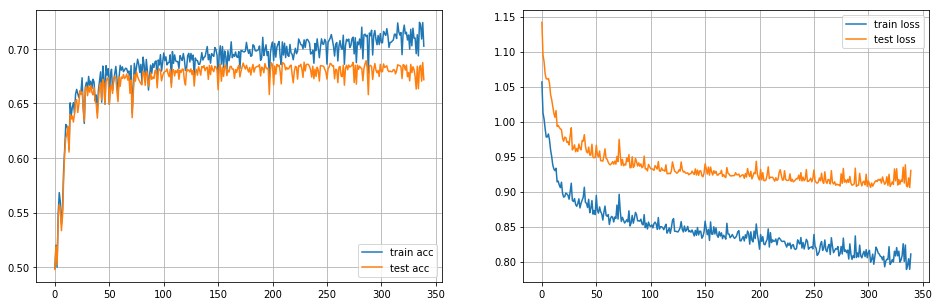

Batch 8513 (2179328 samples) complete

KeyboardInterrupt: 

In [118]:
train_MTRNN_excl1role(0)

Epoch 29 : 0.72657144 0.6768303 0.6394671 loss: 0.79029053 0.9108258 Best test acc res: 0.7082143 0.6840444 0.6519567 236


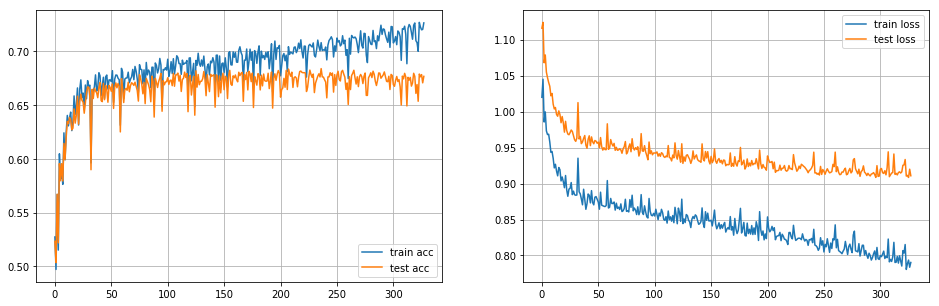

Batch 8220 (2104320 samples) complete

In [123]:
train_MTRNN_excl1role(1)

Epoch 29 : 0.7245714 0.6818464 0.6652789 loss: 0.7894007 0.91376483 Best test acc res: 0.7152857 0.6866934 0.6669442 266


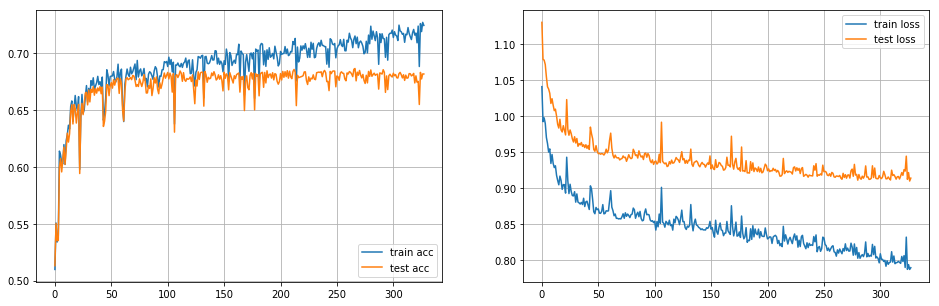

Batch 8220 (2104320 samples) complete

In [124]:
train_MTRNN_excl1role(2)

Epoch 29 : 0.72242856 0.68798965 0.64779353 loss: 0.79343367 0.9074173 Best test acc res: 0.707 0.69435835 0.66111577 235


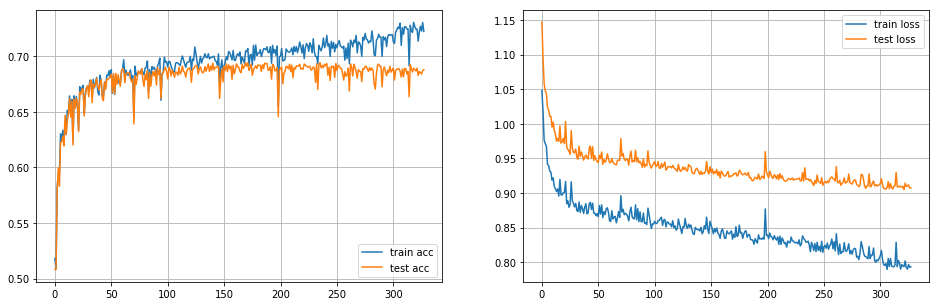

Batch 8220 (2104320 samples) complete

In [125]:
train_MTRNN_excl1role(3)

Epoch 29 : 0.713 0.6694471 0.6515404 loss: 0.8090488 0.92863476 Best test acc res: 0.70357144 0.690244 0.66153204 191


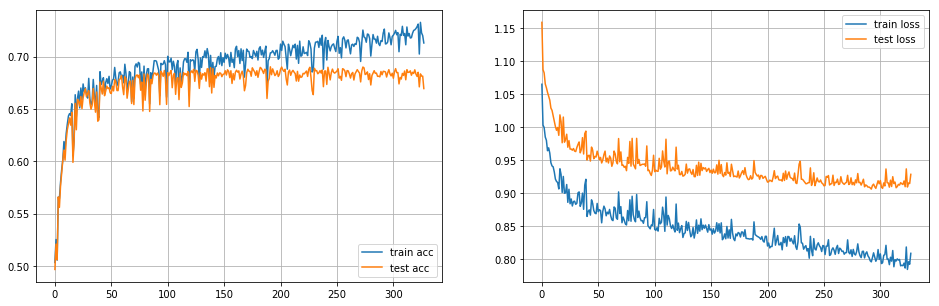

Batch 8220 (2104320 samples) complete

In [126]:
train_MTRNN_excl1role(4)

In [128]:
def train_MTRNN_excl1side(side):
    global epoch_shuf, current_i, epochs_completed
    
    side_i = cols_all.index(side)
    incl_ris = np.asarray([i for i in N_PL_r if i // 5 != side_i]).astype(np.int32)

    excl_feats_psyde = [l for l in X_labels if l.split('_')[0] == side]
    incl_is_psyde = np.asarray([i for i in range(len(X_labels)) if X_labels[i] not in excl_feats_psyde]).astype(np.int32)
    features_incl_psyde = [l for l in X_labels if l not in excl_feats_psyde]
    n_features_incl_psyde = len(features_incl_psyde)
    X_mins_psyde = X_mins[incl_is_psyde]
    pr_fl(n_features_incl_psyde)

    model_name = "rnn_mt_model_EXCL_" + side
    blue_win_i = Yc_use.index("blue_win")
    train_set_test_frac = 0.2 # Get training accuracy for random 20% subset of train set
    log_period_batches = 25
    n_epochs = 30
    learning_rate_amsgrad = 3.5 * 1e-5
    # learning_rate_adam = 3.5 * 1e-5
    # learning_rate_gd = 0.01
    dropout_keep_prob = 0.67
    dropout_rnn = 0.55
    batch_size = 256
    lstm_forget_bias = 1.0
    c_type = "GRU"

    pre_rnn1_units = 256
    # pre_rnn2_units = 256
    # pre_rnn3_units = 256
    # pre_rnn_shared_units = 256
    n_rnn_units = 256
    n_rnn_stacked = 1
    post_rnn_units = 256
    pre_join_x_units = 4096
    l1_n_units = 4096
    l2_n_units = 4096
    l3_n_units = 4096
    l4_n_units = 4096
    # l5_n_units = 4096
    # l6_n_units = 4096
    # final_layer_units = 4096

    # Define next batch function
    current_i, epochs_completed = 0, 0
    epoch_shuf = np.arange(n_train)
    np.random.shuffle(epoch_shuf)
    def next_batch(sz):
        global epoch_shuf, current_i, epochs_completed
        batch_idx = epoch_shuf[current_i:current_i + sz]
        xs = X_train[batch_idx]
        xrs = [Xr_[batch_idx] for Xr_ in Xr_train]
        xrsls = [Xr_sl_[batch_idx] for Xr_sl_ in Xr_sl_train]
        x_chmps = X_champions_train[batch_idx]
        x_pposs = X_pick_positions_train[batch_idx]
        x_spell1s = X_spell1s_train[batch_idx]
        x_spell2s = X_spell2s_train[batch_idx]
        ycs = [Yc_[batch_idx] for Yc_ in Yc_train]
        yrs = [Yr_[batch_idx] for Yr_ in Yr_train]
        current_i += sz
        if current_i >= n_train - 1:
            current_i = 0
            np.random.shuffle(epoch_shuf)
            epochs_completed += 1
        return xs, xrs, xrsls, x_chmps, x_pposs, x_spell1s, x_spell2s, ycs, yrs

    n_train_test = int(train_set_test_frac * n_train)
    izer = tf.contrib.layers.xavier_initializer()
    tf.reset_default_graph()
    train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

    def beta_swish(x):
        beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
        return x * tf.nn.sigmoid(beta * x)
    def swish(x):
        return x * tf.nn.sigmoid(x)
    def autolog(x, x_min, n_feats):
        with tf.name_scope("autolog"):
            alpha = tf.Variable(initial_value=np.tile(0.3, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
            beta = tf.Variable(initial_value=np.tile(0.6, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
            gamma = tf.Variable(initial_value=np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
            act = (alpha * x) + \
                tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
            tf.summary.histogram("autolog_alpha", alpha)
            tf.summary.histogram("autolog_beta", beta)
            tf.summary.histogram("autolog_gamma", gamma)
            tf.summary.histogram("autolog_activation", act)
            return act

    x = tf.placeholder(tf.float32, [None, n_features], name='x')
    xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name=r + "_x_rnn") for r in t_roles]
    xrsl = [tf.placeholder(tf.int32, [None], name="rnn_sequenceLengths_" + r) for r in t_roles]
    x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
    x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
    x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
    x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
    yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name=Yc_use[i] + "_label") for i in range(len(Yc_targets))]
    yr = [tf.placeholder(tf.float32, [None, 1], name=Yr_use[i] + "_target") for i in range(len(Yr_targets))]
    keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
    rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

    # n_input_feats = n_features_incl_psyde
    n_input_feats = n_features_incl_psyde + (n_champions) + (N_PL * 5) + (n_spells * 5)
    
#     x_chmp_ = tf.gather(x_chmp, incl_ris, axis=1)
    x_ppos_ = tf.gather(x_ppos, incl_ris, axis=1)
    x_spell1_ = tf.gather(x_spell1, incl_ris, axis=1)
    x_spell2_ = tf.gather(x_spell2, incl_ris, axis=1)
#     xr = [xr[i] for i in incl_ris]
#     xrsl = [xrsl[i] for i in incl_ris]

    def bnorm_appl(inp):
        return dropout(bnorm(inp), keep_prob)

    with tf.name_scope("get_metadata"):
    #     b_size = tf.shape(x)[0]
        x_eloreg = tf.gather(x, X_eloreg_idx, axis=1)

    with tf.name_scope("recurrent"):
        # Construct pre-rnn layers
        with tf.name_scope("pre_rnn_input"):
            xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
            xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), Xr_mins[i], n_rec_features) if i in incl_ris else None for i in N_PL_r]
        with tf.name_scope("pre_rnn_fc"):
            Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
            Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
            # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
            # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
            # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
            # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
            # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
            # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

            pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] if i in incl_ris else None for i in N_PL_r]
            # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
            # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
            # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
            pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) if i in incl_ris else None for i in N_PL_r]

        with tf.name_scope("rnn_layers"):
            def get_rnn_cell(c_type, lstm_forget_bias, kp):
              cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
                     rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell")
              return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
            if n_rnn_stacked > 1:
            #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
                cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
            else:
            #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
                cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)

            with tf.name_scope("rnn_beginToken_W"):
                # W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
                W_begin_token = [tf.Variable(izer([len(X_eloreg_idx), n_rnn_units]), name=r) for r in roles_all]
            with tf.name_scope("rnn_beginToken_b"):
                b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

            # Define rnn cell initial state
            init_states = [tf.matmul(x_eloreg, W_begin_token[i]) + b_begin_token[i] for i in range(5)]
            # init_states = [tf.tile(W_begin_token[i], [b_size, 1]) for i in range(5)]
            rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i % 5],
                                        dtype=tf.float32) for i in incl_ris])
            # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
            #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
            #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
            rnn_outs = [tf.gather_nd(rnn_os[np.where(incl_ris == i)[0][0]], tf.stack([tf.range(tf.shape(rnn_os[np.where(incl_ris == i)[0][0]])[0]), \
                        xrsl[i] - 1], axis=1)) if i in incl_ris else None for i in N_PL_r]

        with tf.name_scope("post_rnn_fc"):
            Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
            Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
            Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
            # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

            post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) if i in incl_ris else None for i in N_PL_r]
            rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) if i in incl_ris else None for i in N_PL_r]  # Sum join

    with tf.name_scope("fully_connected"):

        with tf.name_scope("fc_input"):
            # Add champion compositions and pick positions
            x_champsum = tf.one_hot(x_chmp, n_champions)
            x_pposes = tf.one_hot(x_ppos_, N_PL)
            x_ch_sum = tf.reduce_sum(x_champsum[:, :5] if side == "red" else x_champsum[:, 5:], axis=1)
            x_spellsum = tf.one_hot(x_spell1_, n_spells) + tf.one_hot(x_spell2_, n_spells)
            x_input = tf.concat([autolog(tf.gather(x, incl_is_psyde, axis=1), X_mins_psyde, n_features_incl_psyde),
                                 x_ch_sum,
                                 tf.reshape(x_pposes, [-1, 5 * N_PL]),
                                 tf.reshape(x_spellsum, [-1, 5 * n_spells])], axis=1)

        with tf.name_scope("fc_layers"):
            Wp_1 = tf.Variable(izer([n_input_feats, pre_join_x_units]), name='W_xin_linear')
            bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

            W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
            # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
            b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
            W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
            b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
            W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
            b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
            W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
            b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
            # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
            # b_5 = tf.Variable(izer([l5_n_units]))
            # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
            # b_6 = tf.Variable(izer([l6_n_units]))
            # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
            # b_7 = tf.Variable(izer([n_outputs]))

            pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

            relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum([l_ for l_ in rnn_l1 if l_ is not None]))  # Sum join
            # relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

            relu_2 = bnorm_appl(tf.matmul(relu_1, W_2) + b_2)
            relu_3 = bnorm_appl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
            relu_4 = bnorm_appl(tf.matmul(relu_3, W_4) + b_4)
            # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
            # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
            # drop_out = dropout(relu_2, keep_prob)
            # y_out = tf.matmul(drop_out, W_3) + b_3
            # y_out = tf.matmul(relu_3, W_4) + b_4
            #   y_prob = tf.nn.softmax(y_out)

        with tf.name_scope("final_output"):
            # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
            # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
            # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
            # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
            # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
            # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
            # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
            # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

            with tf.name_scope("output_W"):
                Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
                Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
            with tf.name_scope("output_b"):
                Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
                Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

            # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
            # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
            # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
            # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

            with tf.name_scope("classif_outs"):
                Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
            with tf.name_scope("regr_outs"):
                Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

    # Define loss function & training step
    with tf.name_scope("loss"):
        Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                     labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
        Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
        # loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
        loss = sum(Yc_losses) + (5.0 * (10**-5) * tf.reduce_mean(Yr_losses))

    with tf.name_scope("train"):
        train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
        # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)

    with tf.name_scope("accuracy"):
        # Define accuracy computation
        correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
        accuracy = tf.reduce_mean(correct)
        accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

    tf.summary.scalar("loss", loss)
    tf.summary.scalar("accuracy", accuracy)
    merged_summary = tf.summary.merge_all()

    # Train
    batch_i = 0
    best_acc = 0
    saver = tf.train.Saver()
    create_folder("models")
    create_folder("models/" + model_name)
    create_folder("model_formats")
    create_folder(learning_data_dir)
    create_folder(learning_data_dir + "models")
    save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())  # Comment this out if resuming!
        writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
        writer.add_graph(sess.graph)
        while epochs_completed < n_epochs:

            batch_i += 1
            batch_xs, batch_xrs, batch_xrsls, batch_xchs, batch_xppos, \
                batch_xspell1, batch_xspell2, batch_ycs, batch_yrs = next_batch(batch_size)
            xrs_feed = {xr[i]: batch_xrs[i] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: batch_xrsls[i] for i in N_PL_r}
            ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
            sess.run([train_step], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                **{x: batch_xs, x_chmp: batch_xchs, x_ppos: batch_xppos, x_spell1: batch_xspell1, x_spell2: batch_xspell2, \
                   keep_prob: dropout_keep_prob, rnn_kp: dropout_rnn}})
#             writer.add_summary(s, batch_i)
            sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')

            if batch_i % log_period_batches == 0:
                indices = np.random.choice(n_train, n_train_test, replace=False)
                xrs_feed = {xr[i]: Xr_train[i][indices] for i in N_PL_r}
                xrsls_feed = {xrsl[i]: Xr_sl_train[i][indices] for i in N_PL_r}
                ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
                yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
                train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                       {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                     **{x: X_train[indices], x_chmp: X_champions_train[indices], x_ppos: X_pick_positions_train[indices], \
                        x_spell1: X_spell1s_train[indices], x_spell2: X_spell2s_train[indices], \
                        keep_prob: 1.0, rnn_kp: 1.0}})

                xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
                xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
                ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
                yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
                test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                      {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                    **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
                       x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
                       keep_prob: 1.0, rnn_kp: 1.0}})

                train_loss += [ train_l ]
                train_accuracy += [ train_a ]
                test_loss += [ test_l ]
                test_accuracy += [ test_a ]

                if test_a > best_acc:
                    best_acc = test_a
                    best_acc_he = test_he
                    best_acc_tr = train_a
                    saver.save(sess, "./models/" + model_name + '/' + model_name)

                clear_output()
                print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
                      "Best test acc res:", best_acc_tr, max(test_accuracy), best_acc_he, np.argmax(test_accuracy))
                fig = plt.figure()
                fig.set_size_inches(16, 5)
                g = fig.add_subplot(1,2,1)
                g.grid()
                g.plot(train_accuracy, label='train acc')
                g.plot(test_accuracy, label='test acc')
                g.legend(loc='lower right')

                g = fig.add_subplot(1,2,2)
                g.grid()
                g.plot(train_loss, label='train loss')
                g.plot(test_loss, label='test loss')
                g.legend(loc='upper right')

                save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                        model_name + '_log')
                graphs_folder = "graphs"
                create_folder(graphs_folder)
                plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
                plt.show()

    # Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss)

Epoch 29 : 0.68385714 0.6423378 0.6157369 loss: 0.8406331 0.9449036 Best test acc res: 0.66578573 0.6505101 0.61948377 196


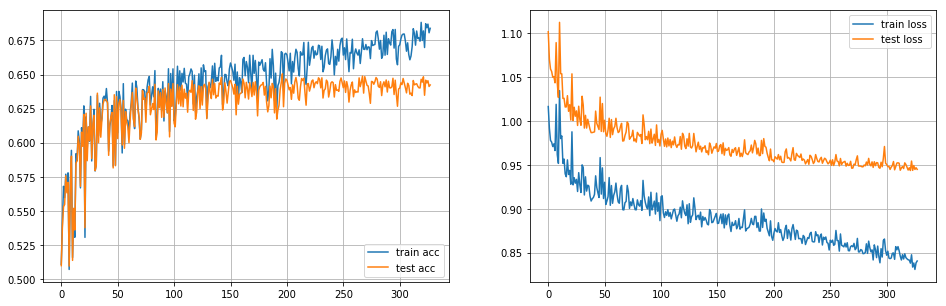

Batch 8220 (2104320 samples) complete

In [131]:
train_MTRNN_excl1side("blue")

Epoch 29 : 0.6832143 0.6427323 0.61032474 loss: 0.84885776 0.9513236 Best test acc res: 0.6792857 0.6457194 0.62323064 294


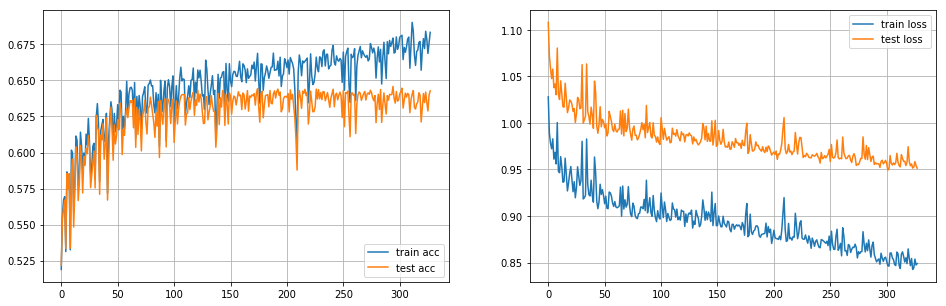

Batch 8220 (2104320 samples) complete

In [132]:
train_MTRNN_excl1side("red")

Epoch 17 : 0.7227857 0.68567884 0.6465446 loss: 0.7880803 0.8994597 Best test acc res: 0.7227143 0.6921039 0.6602831 180


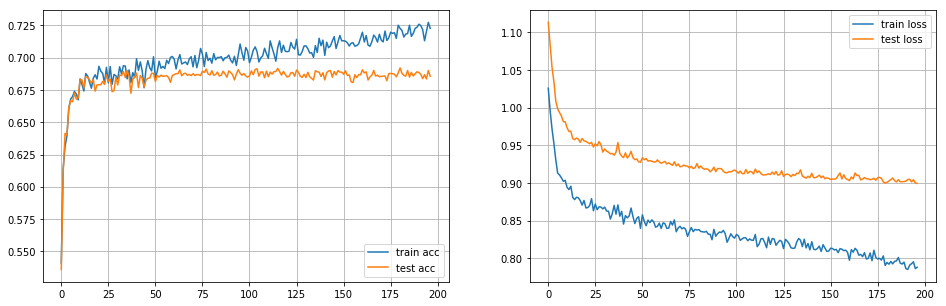

Batch 4933 (1262848 samples) complete

KeyboardInterrupt: 

In [405]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    create_folder("logs/tensorboard/" + model_name, overwrite=True)
    writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
    writer.add_graph(sess.graph)
    while epochs_completed < n_epochs:

        batch_i += 1
        batch_xs, batch_xrs, batch_xrsls, batch_xchs, batch_xppos, \
            batch_xspell1, batch_xspell2, batch_ycs, batch_yrs = next_batch(batch_size)
        xrs_feed = {xr[i]: batch_xrs[i] for i in N_PL_r}
        xrsls_feed = {xrsl[i]: batch_xrsls[i] for i in N_PL_r}
        ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
        _, s = sess.run([train_step, merged_summary], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
            **{x: batch_xs, x_chmp: batch_xchs, x_ppos: batch_xppos, x_spell1: batch_xspell1, x_spell2: batch_xspell2, \
               keep_prob: dropout_keep_prob, rnn_kp: dropout_rnn}})
        writer.add_summary(s, batch_i)
        sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')

        if batch_i % log_period_batches == 0:
            indices = np.random.choice(n_train, n_train_test, replace=False)
            xrs_feed = {xr[i]: Xr_train[i][indices] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_train[i][indices] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
            train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                   {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                 **{x: X_train[indices], x_chmp: X_champions_train[indices], x_ppos: X_pick_positions_train[indices], \
                    x_spell1: X_spell1s_train[indices], x_spell2: X_spell2s_train[indices], \
                    keep_prob: 1.0, rnn_kp: 1.0}})
            
            xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
            test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                  {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
                   x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
                   keep_prob: 1.0, rnn_kp: 1.0}})
            
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc:
                best_acc = test_a
                best_acc_he = test_he
                best_acc_tr = train_a
                saver.save(sess, "./models/" + model_name + '/' + model_name)

            clear_output()
            print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
                  "Best test acc res:", best_acc_tr, max(test_accuracy), best_acc_he, np.argmax(test_accuracy))
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')

            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                    model_name + '_log')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

# Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss)

In [13]:
yr_scaler = RobustScaler()
yr_scaler.fit(Yr[:n_train])
Yr = yr_scaler.transform(Yr)